In [1]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import h5py
from pylab import rcParams
import pandas as pd
import os
from tqdm import tqdm
rcParams['figure.figsize'] = 20,9

In [2]:
clases=['muon','electron','piminus']

In [3]:
f = h5py.File('logs/predictions_default.h5', 'r')
pred = {'run':np.array(f['runs']),
        'subrun':np.array(f['subruns']),
        'evt':np.array(f['evts']),
        'label':np.array(f['labels']),
        'cycle':np.array(f['cycles']),}
probs = pd.DataFrame(np.array(f['probs']), columns=['pdm', 'pde', 'pdp'])
probs['y_preds']= np.argmax(np.array(f['probs']), axis=1)
probs['predict']=probs['y_preds'].apply(lambda x: clases[x])

dfpred = pd.DataFrame(pred)
dfpred = pd.concat([dfpred, probs], axis=1, join='inner').reset_index()


In [4]:
dfpred

,index,run,subrun,evt,label,cycle,pdm,pde,pdp,y_preds,predict
0,0,12035,0,1222,1,0,6.025143e-05,0.995903,4.036321e-03,1,electron
1,1,12037,22,563,1,0,4.343346e-19,1.000000,2.051067e-09,1,electron
2,2,13183,15,1821,1,0,1.450350e-03,0.982047,1.650249e-02,1,electron
3,3,11572,23,1170,0,0,9.927921e-01,0.000015,7.192424e-03,0,muon
4,4,10855,7,824,1,0,2.274239e-01,0.386103,3.864733e-01,2,piminus
...,...,...,...,...,...,...,...,...,...,...,...
14940,14940,10641,11,1111,1,0,3.206415e-09,0.999949,5.064414e-05,1,electron
14941,14941,13281,14,57,0,0,9.870310e-01,0.000120,1.284930e-02,0,muon
14942,14942,11977,12,963,1,0,4.142592e-03,0.496207,4.996505e-01,2,piminus
14943,14943,13263,0,1146,1,0,9.752432e-01,0.001053,2.370390e-02,0,muon


In [5]:
files = [os.path.join('data/dataset/',f) for f in os.listdir('data/dataset/')]
dfdata=pd.DataFrame()
for f in tqdm(files):
    clases=['muon','electron','piminus']
    h5 = h5py.File(f, 'r')

    keys = ['E', 'azimuth', 'cycle', 'eff', 'enter.x', 'enter.y', 'enter.z', 'evt', 'exit.x', 'exit.y', 'exit.z',
            'nhitslc', 'nhittot', 'p.E', 'p.px', 'p.py', 'p.pz', 'pdg', 'penter.E', 'penter.px', 'penter.py', 'penter.pz',
            'rec.mc.cosmic_idx', 'run', 'stop.x', 'stop.y', 'stop.z', 'subevt', 'subrun', 'time', 'visE', 'visEinslc',
            'vtx.x', 'vtx.y', 'vtx.z', 'zenith']
    data = {}
    for k in keys:
        data[k] = np.array(h5[k])

    data = pd.DataFrame(data)

    dfpm=pd.DataFrame(h5['cvnmap'])

    data['euclidean'] = (((data['vtx.x'] - data['stop.x']) ** 2) +
                         (data['vtx.y'] - data['stop.y']) ** 2 +
                         (data['vtx.z'] - data['stop.z']) ** 2) ** .5


    def set_values(row, value):
        return value[row]


    map_dictionary = {11: 1, 13: 0, -211:2}

    data['label'] = data['pdg'].apply(set_values, args=(map_dictionary,))
    h5.close()
    data=pd.concat([data,dfpm], axis=1, join='inner')
    del dfpm
    data = pd.merge(dfpred, data,on= ['evt','run','subrun','cycle','label'], how='inner')
    dfdata=pd.concat([dfdata, data],
                  ignore_index = True)
dfpred = dfdata

100%|██████████| 2989/2989 [06:59<00:00,  7.12it/s]


In [6]:
dfpred


,index,run,subrun,evt,label,cycle,pdm,pde,pdp,y_preds,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
0,7964,11309,19,1530,1,0,6.706400e-09,9.999297e-01,7.033531e-05,1,...,0,0,0,0,0,0,0,0,0,0
1,10946,11309,19,913,1,0,5.564277e-09,9.999353e-01,6.472675e-05,1,...,0,0,0,0,0,0,0,0,0,0
2,2246,12016,17,194,1,0,1.036239e-03,8.476382e-01,1.513255e-01,1,...,0,0,0,0,0,0,0,0,0,0
3,10753,12016,17,1513,1,0,1.562876e-03,9.370614e-01,6.137579e-02,1,...,0,0,0,0,0,0,0,0,0,0
4,12709,12016,17,1346,1,0,2.529246e-15,9.999999e-01,9.726185e-08,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14940,7527,11446,0,1137,0,0,9.869469e-01,1.223495e-04,1.293068e-02,0,...,0,0,0,0,0,0,0,0,0,0
14941,11517,11446,0,1626,0,0,9.807932e-01,4.566931e-04,1.875007e-02,0,...,0,0,0,0,0,0,0,0,0,0
14942,13332,11446,0,30,0,0,9.976075e-01,3.230286e-07,2.392147e-03,0,...,0,0,0,0,0,0,0,0,0,0
14943,14081,11446,0,1531,0,0,9.612151e-01,4.129274e-03,3.465550e-02,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:

df=dfpred[dfpred['label']==1]
df=df[df['p.E']>4]

df=df.sample(100)

In [8]:
df

,index,run,subrun,evt,label,cycle,pdm,pde,pdp,y_preds,...,15990,15991,15992,15993,15994,15995,15996,15997,15998,15999
9454,1670,11342,5,1149,1,0,1.384309e-18,1.000000,3.436037e-09,1,...,0,0,0,0,0,0,0,0,0,0
8152,9008,10652,10,1801,1,1,3.052804e-07,0.999615,3.847733e-04,1,...,0,0,0,0,0,0,0,0,0,0
13290,7426,11993,10,554,1,0,1.475399e-10,0.999987,1.286351e-05,1,...,0,0,0,0,0,0,0,0,0,0
9551,29,10909,23,187,1,0,7.516631e-09,0.999926,7.399822e-05,1,...,0,0,0,0,0,0,0,0,0,0
10379,7967,10855,7,829,1,0,1.020649e-11,0.999996,3.917458e-06,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8857,5015,10606,3,944,1,0,3.730660e-23,1.000000,3.177539e-11,1,...,0,0,0,0,0,0,0,0,0,0
14543,11656,10931,23,1884,1,0,8.917709e-20,1.000000,1.013738e-09,1,...,0,0,0,0,0,0,0,0,0,0
11906,11918,12038,18,1155,1,0,9.797496e-16,1.000000,6.376861e-08,1,...,0,0,0,0,0,0,0,0,0,0
6382,8106,10620,8,229,1,0,3.964926e-13,0.999999,9.227747e-07,1,...,0,0,0,0,0,0,0,0,0,0


/tmp/ipykernel_5094/1436796425.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


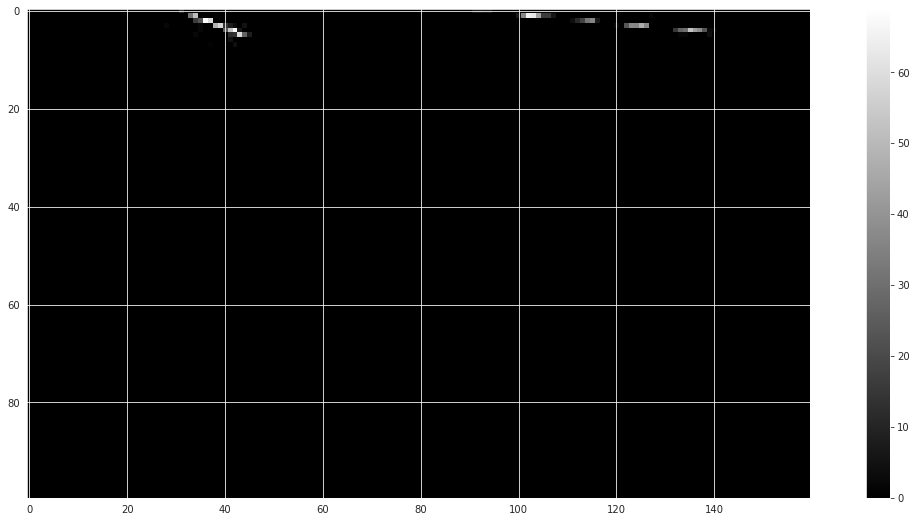

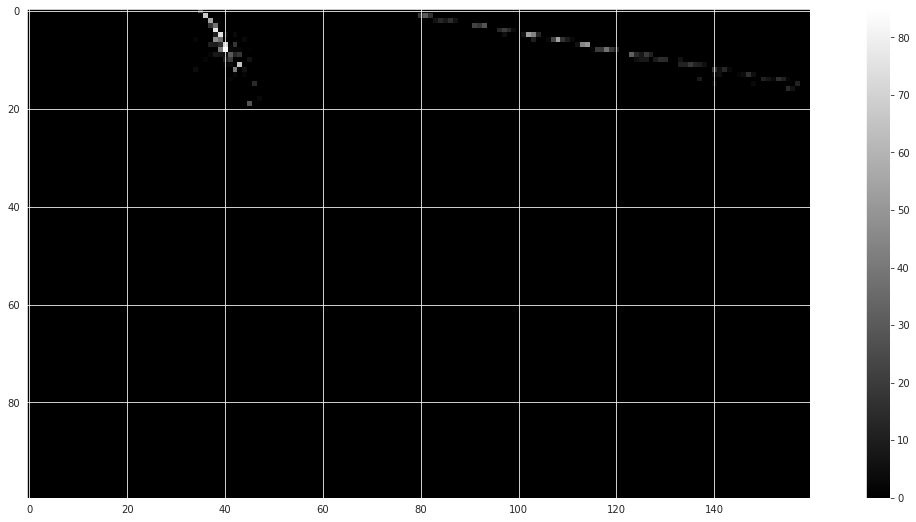

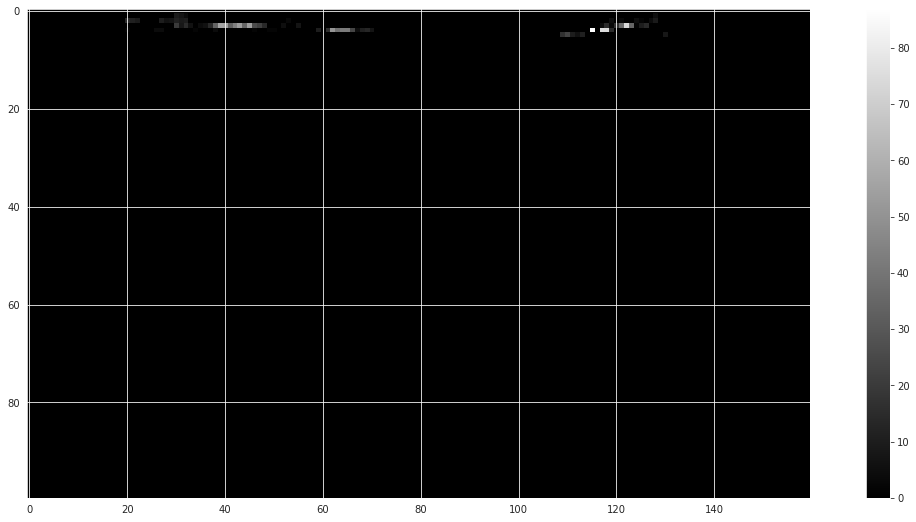

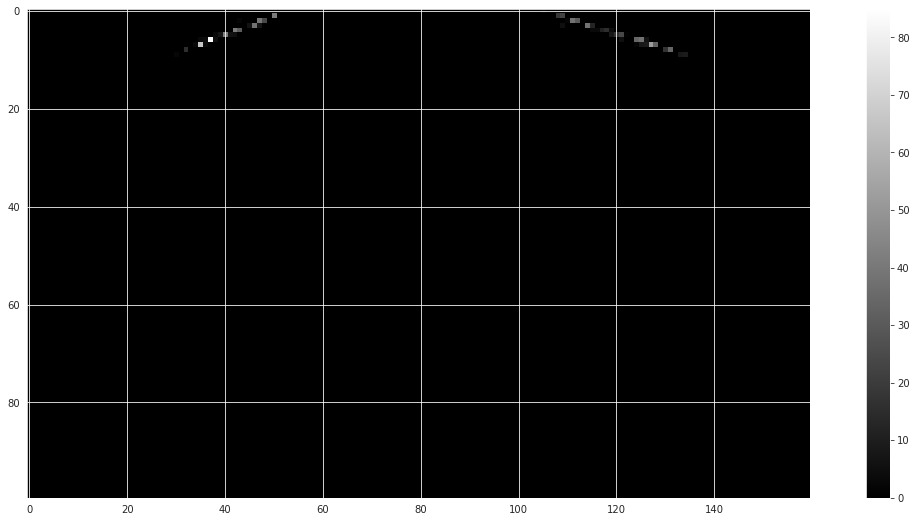

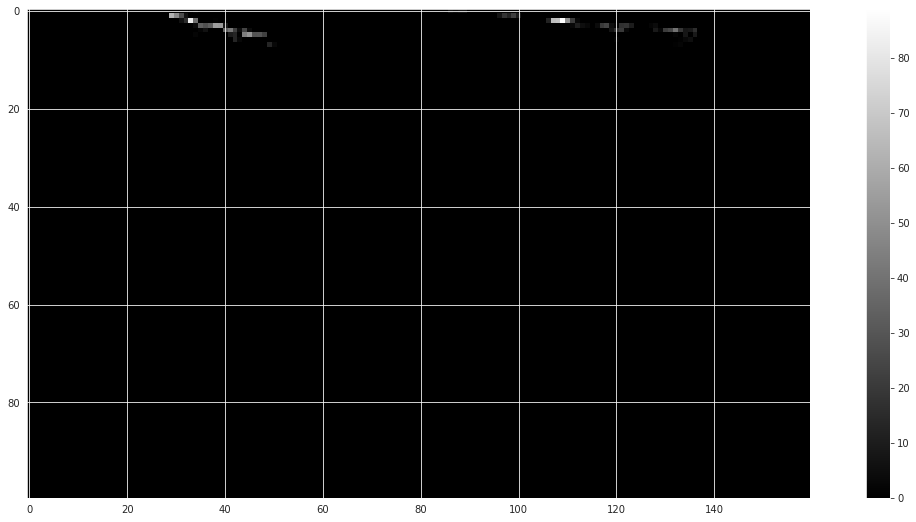

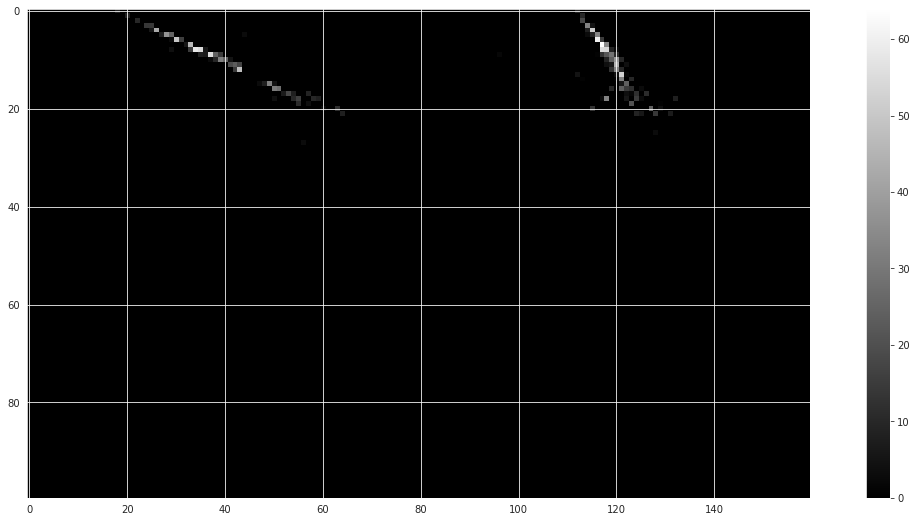

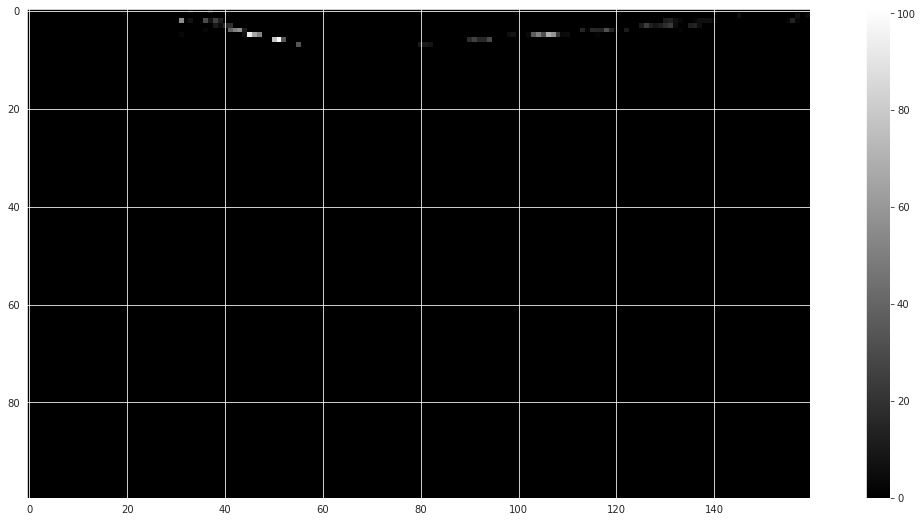

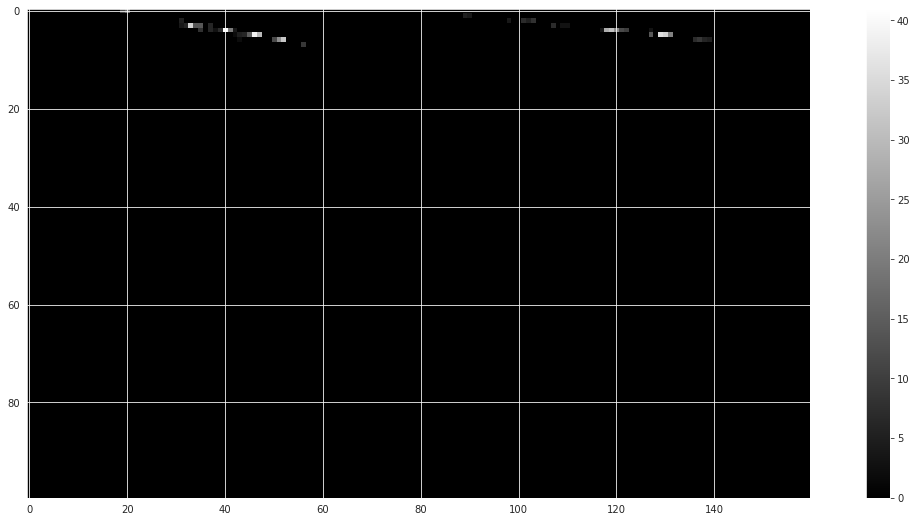

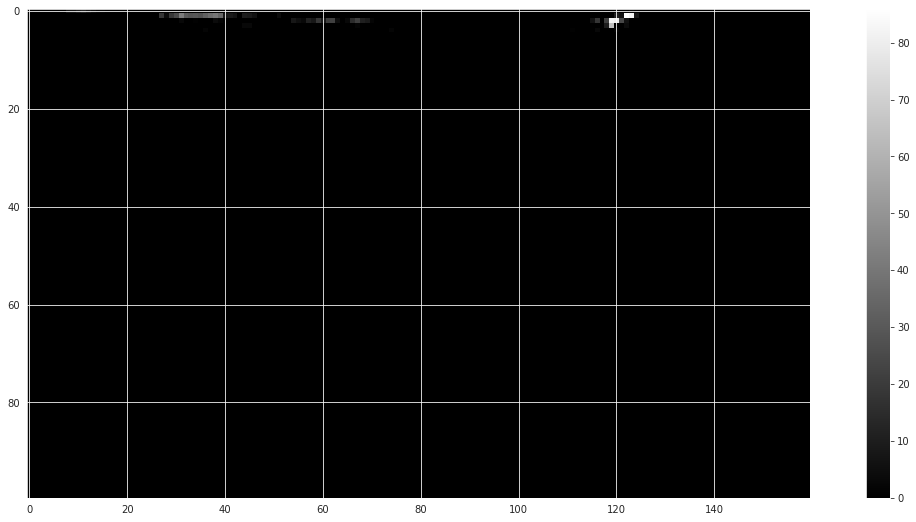

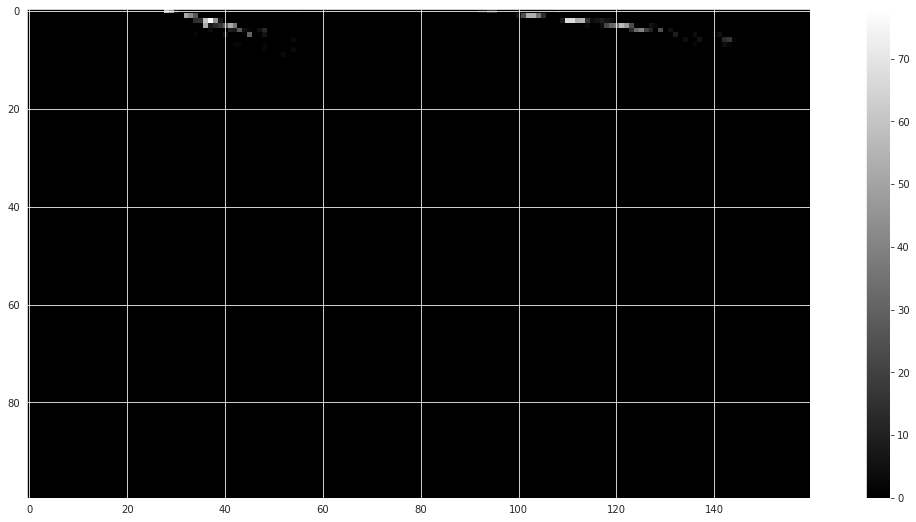

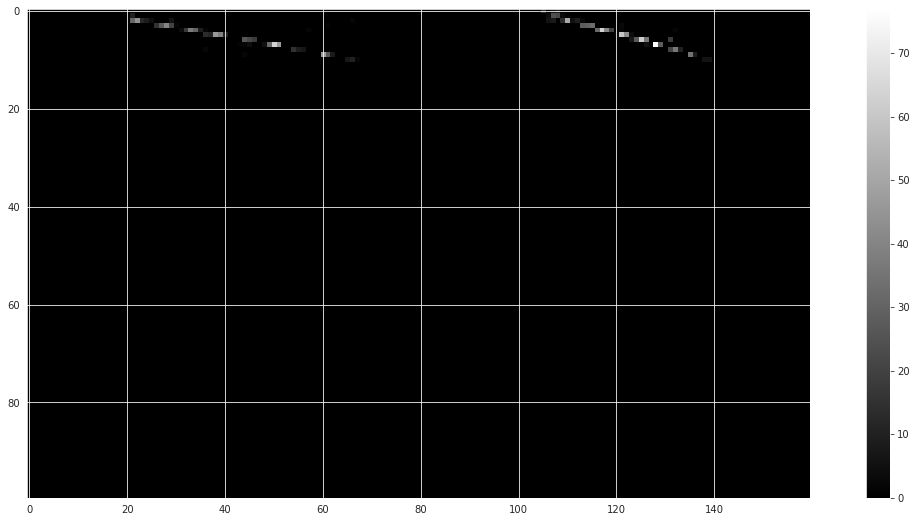

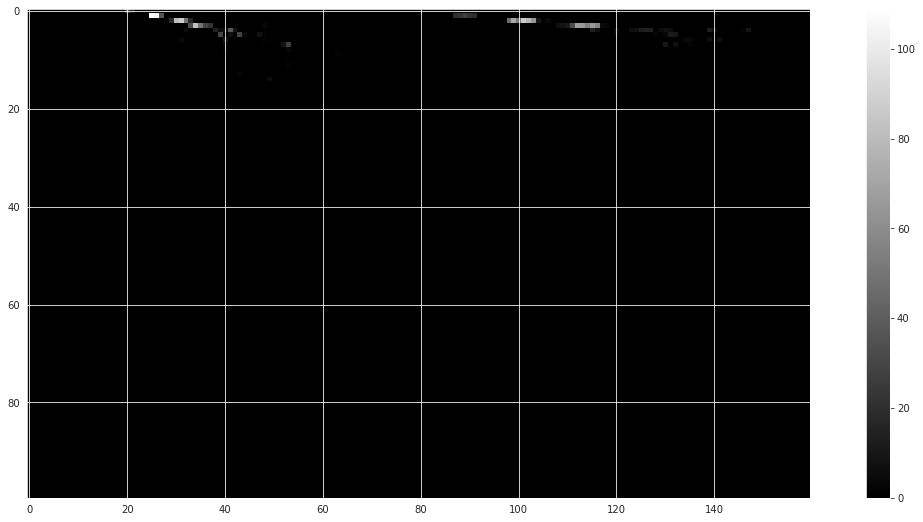

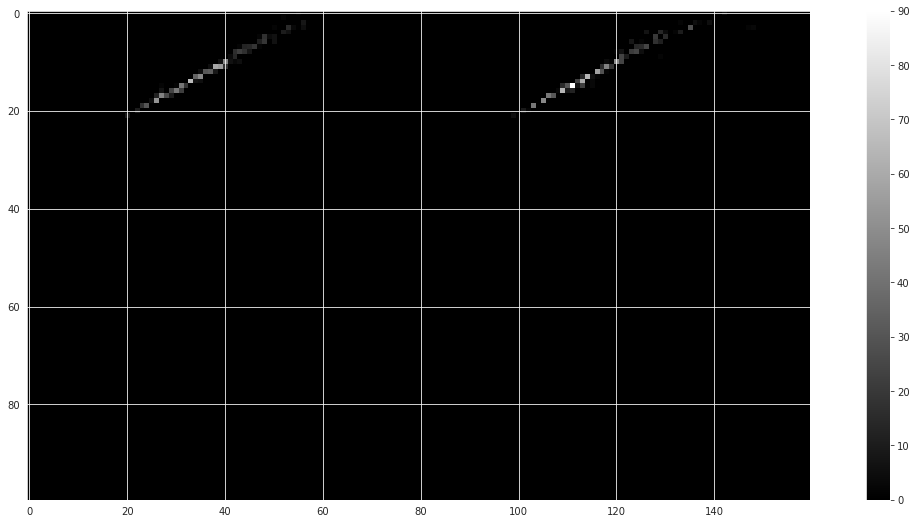

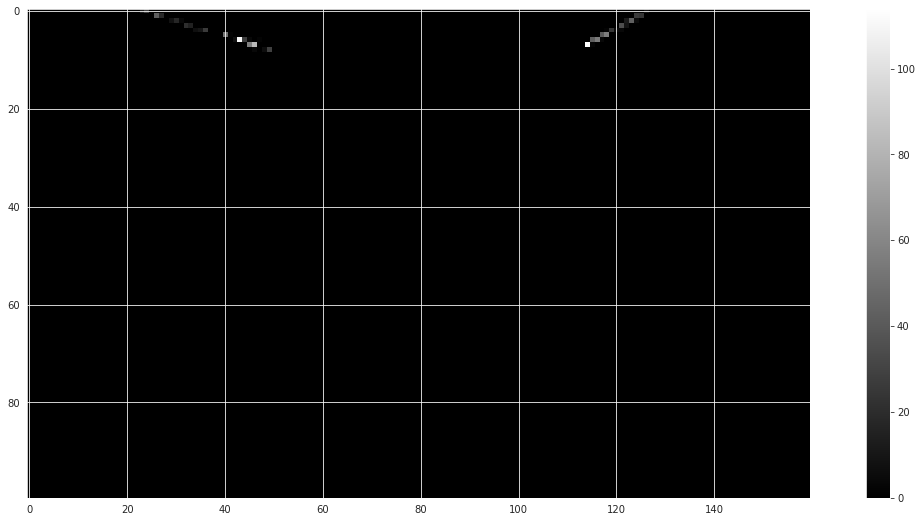

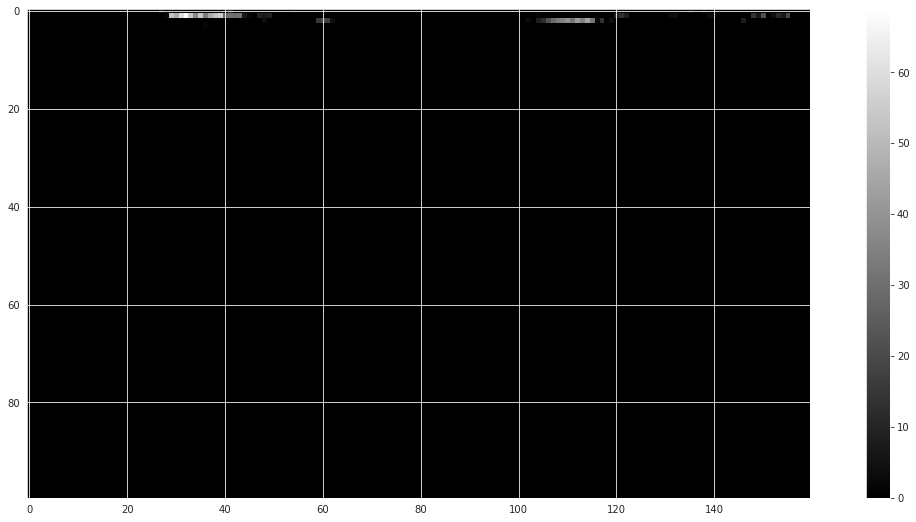

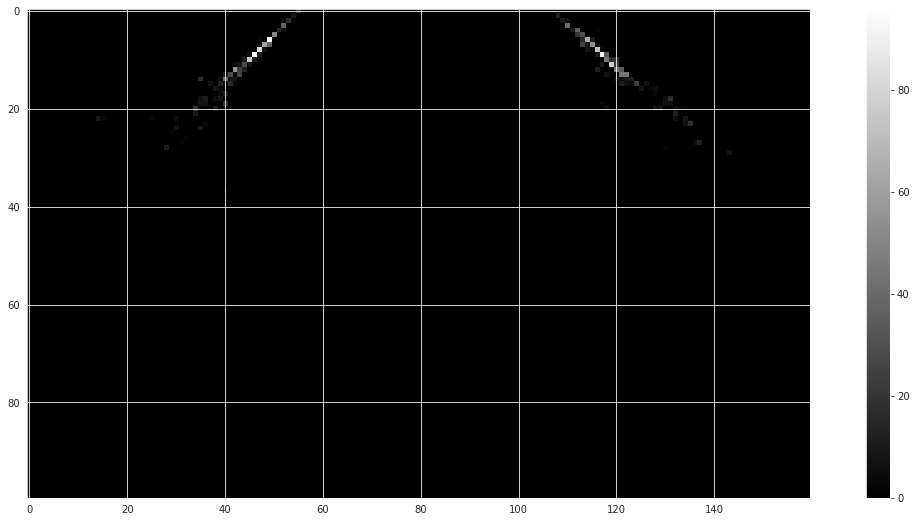

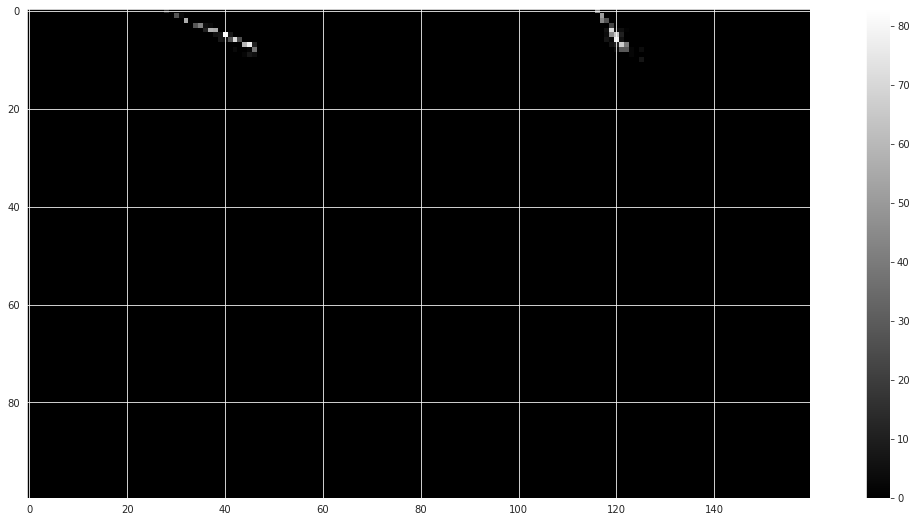

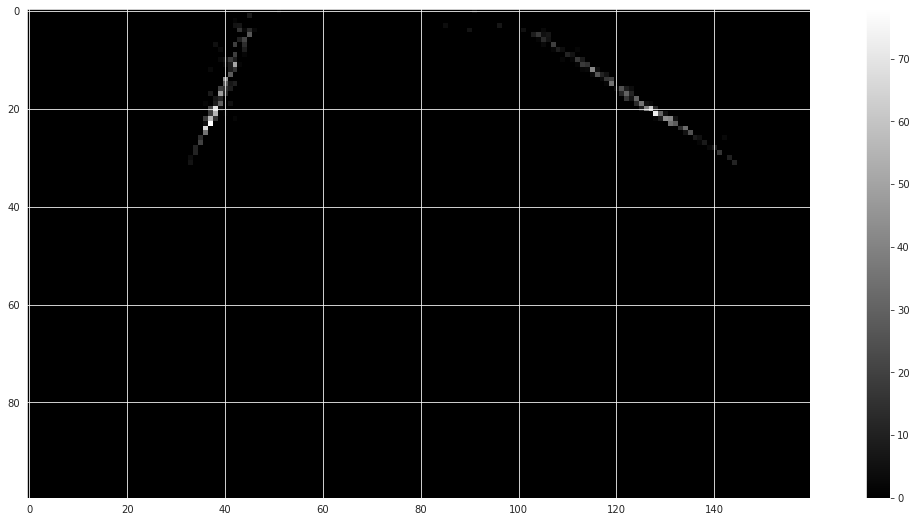

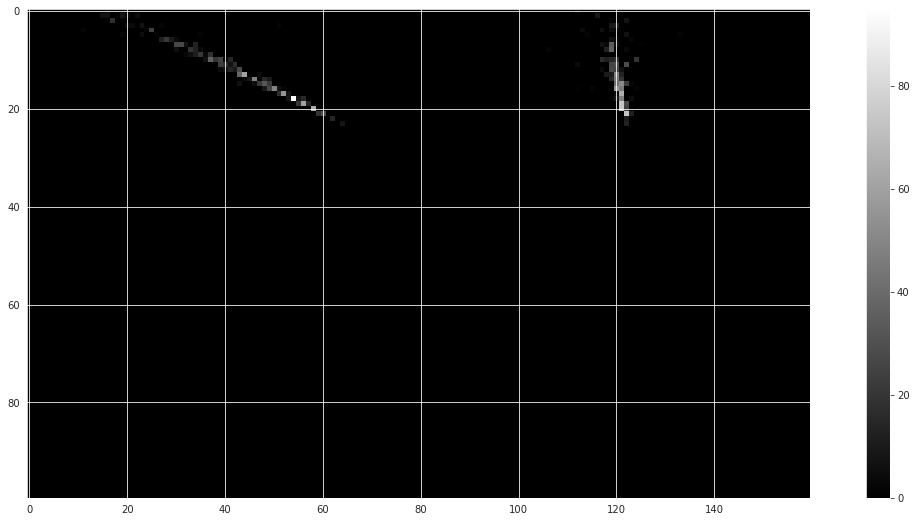

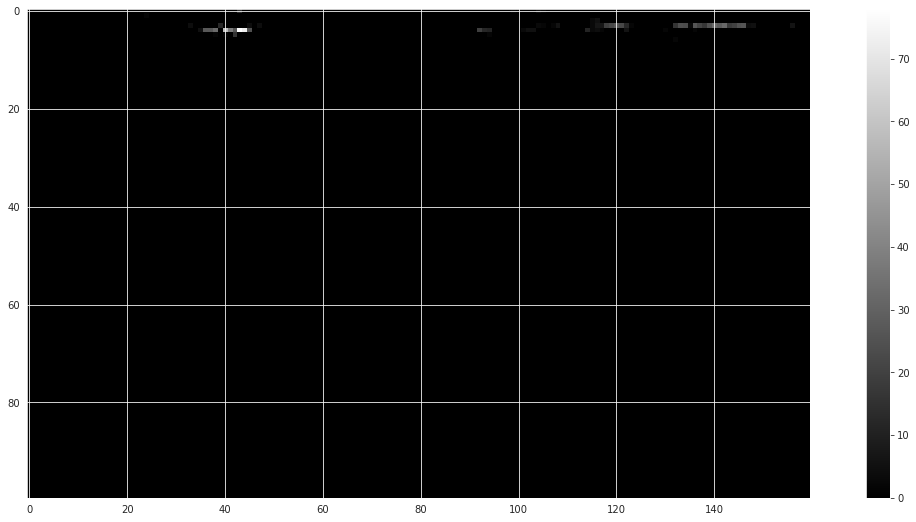

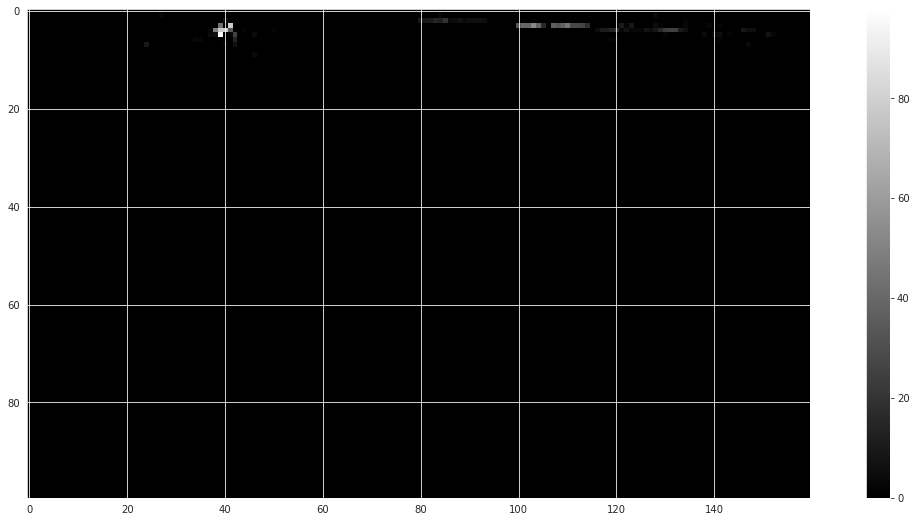

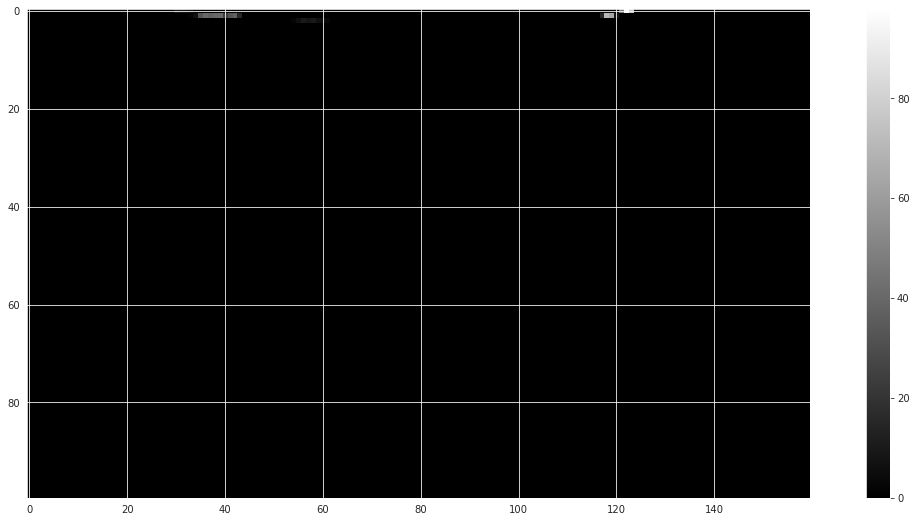

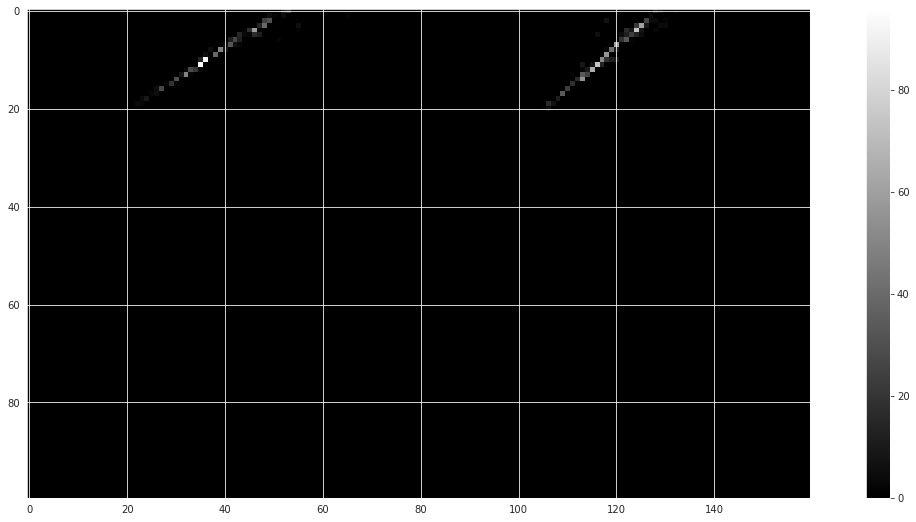

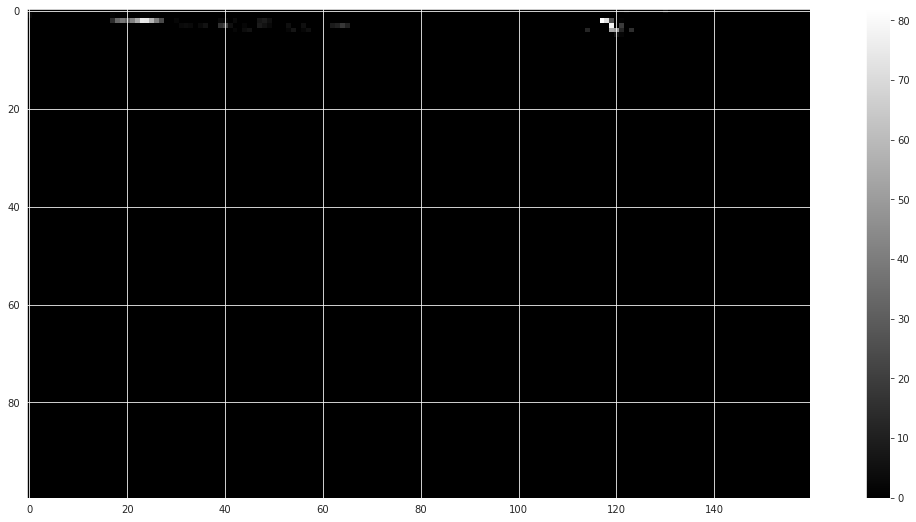

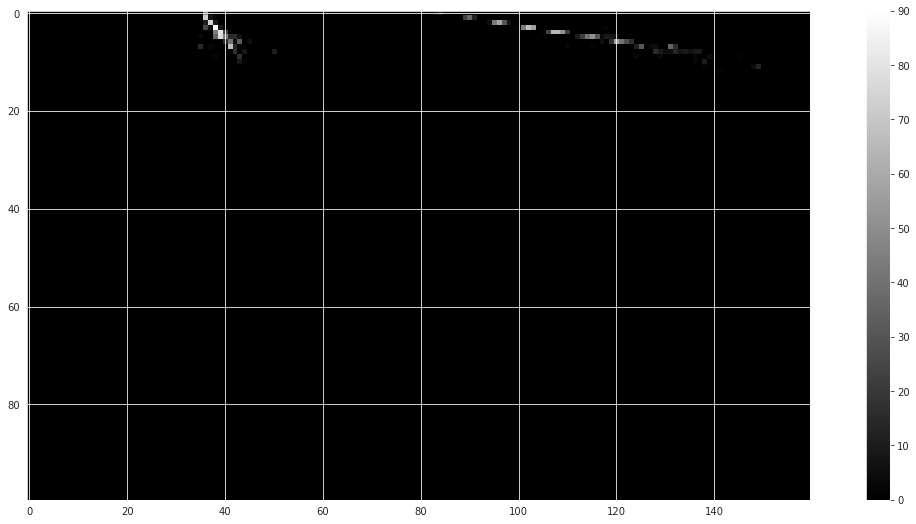

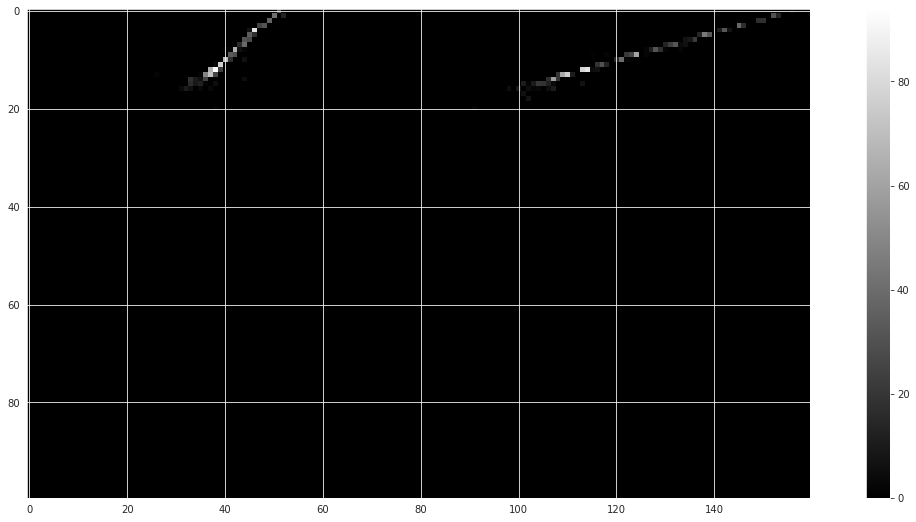

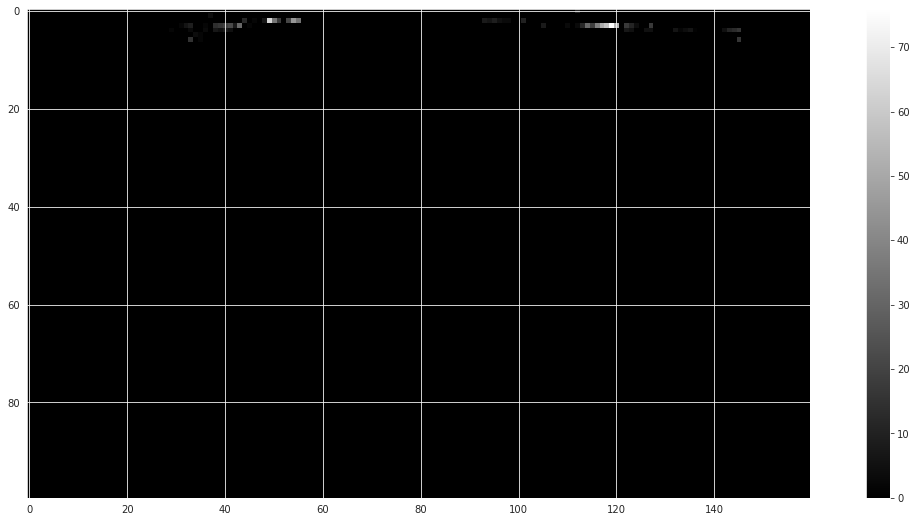

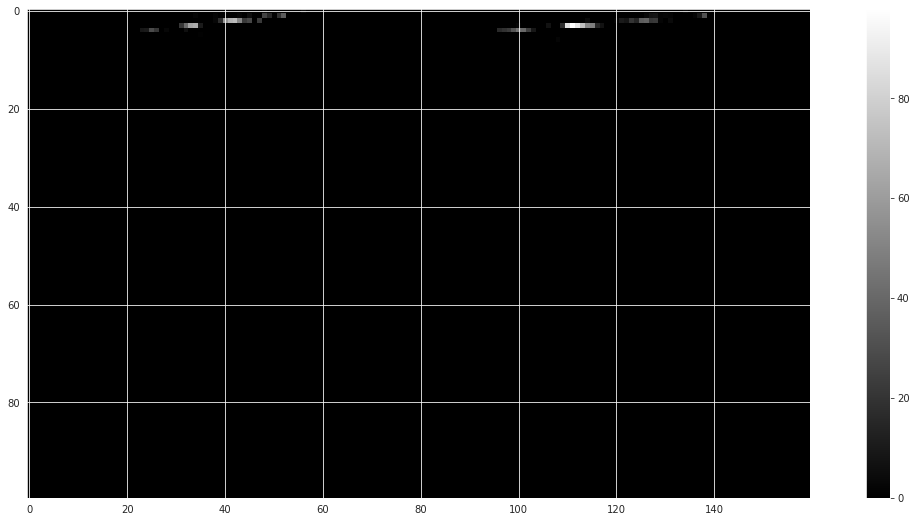

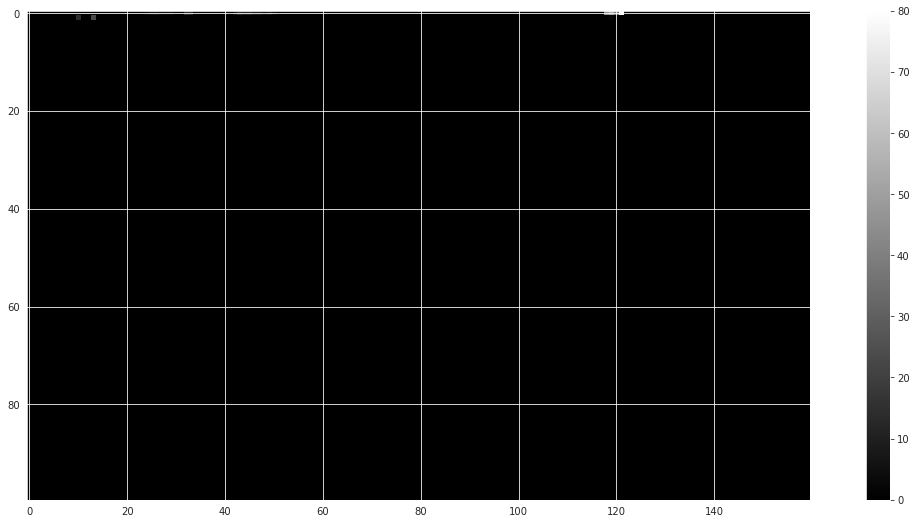

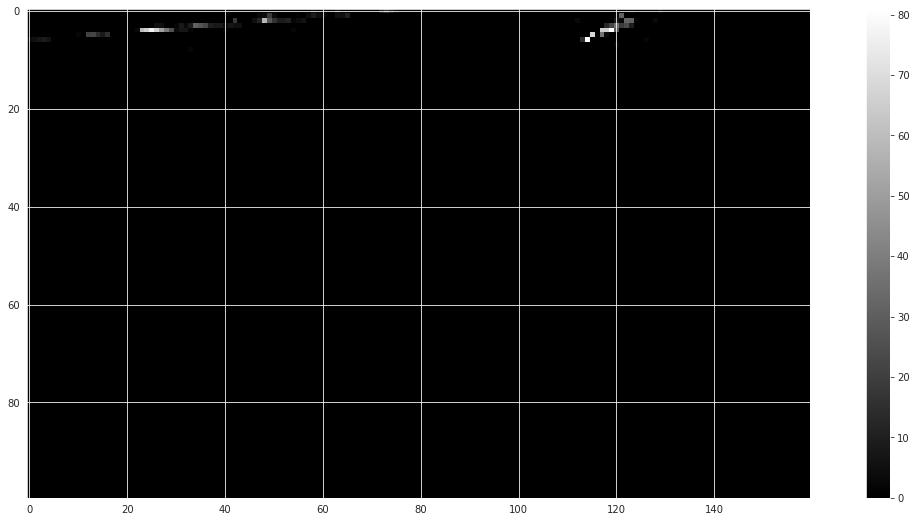

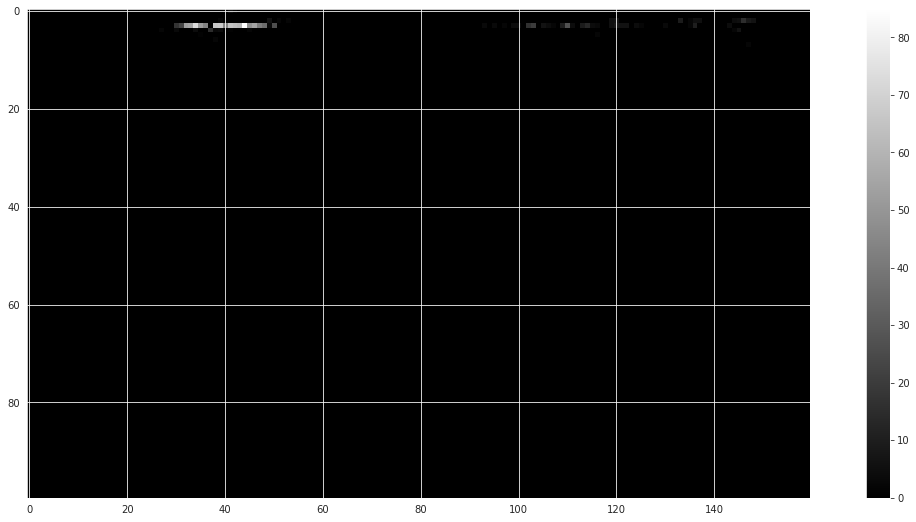

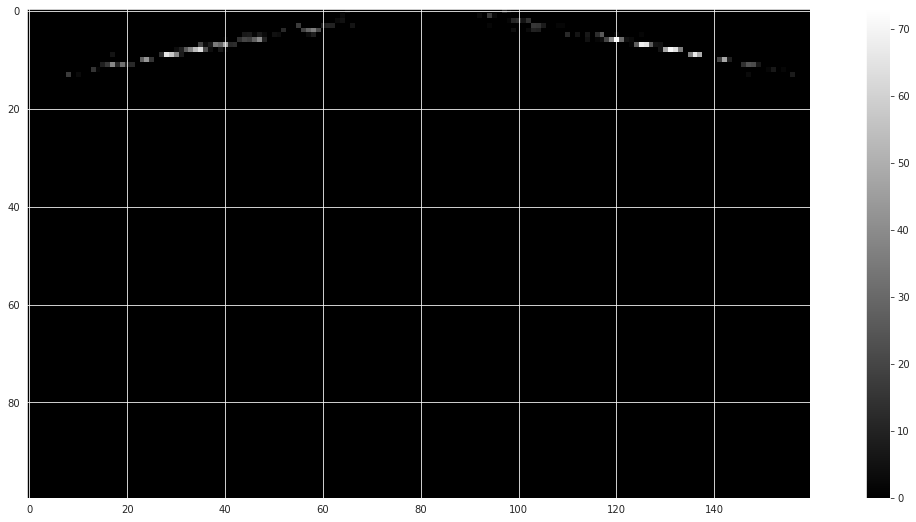

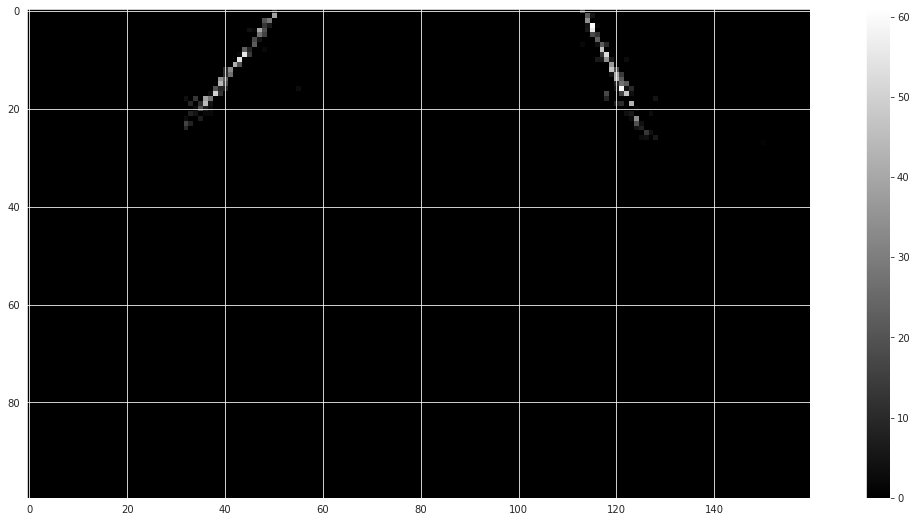

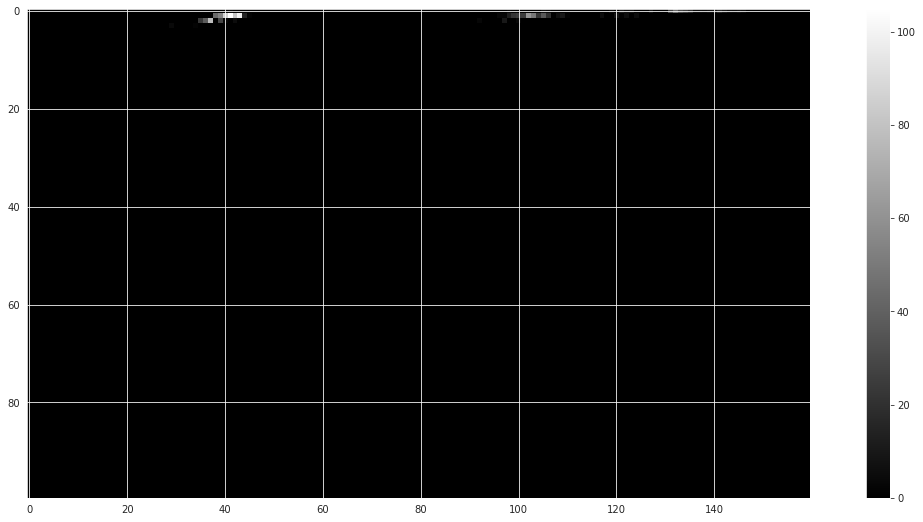

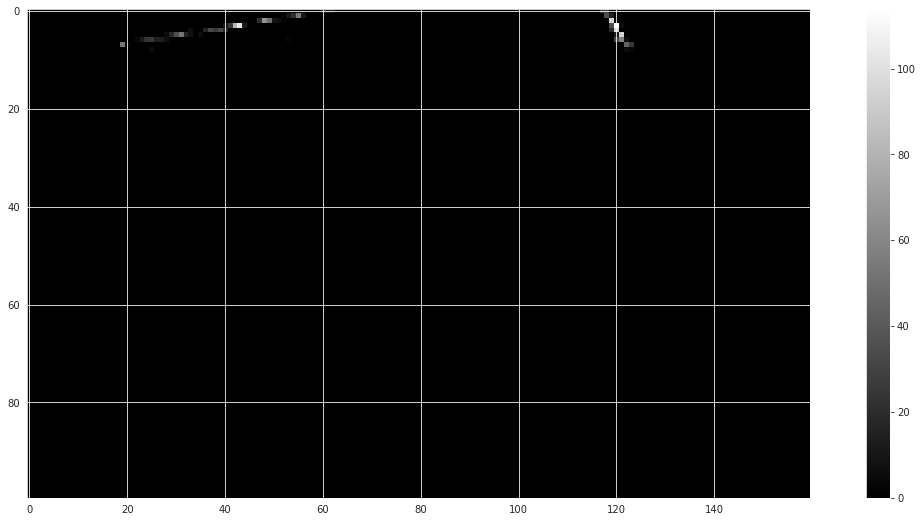

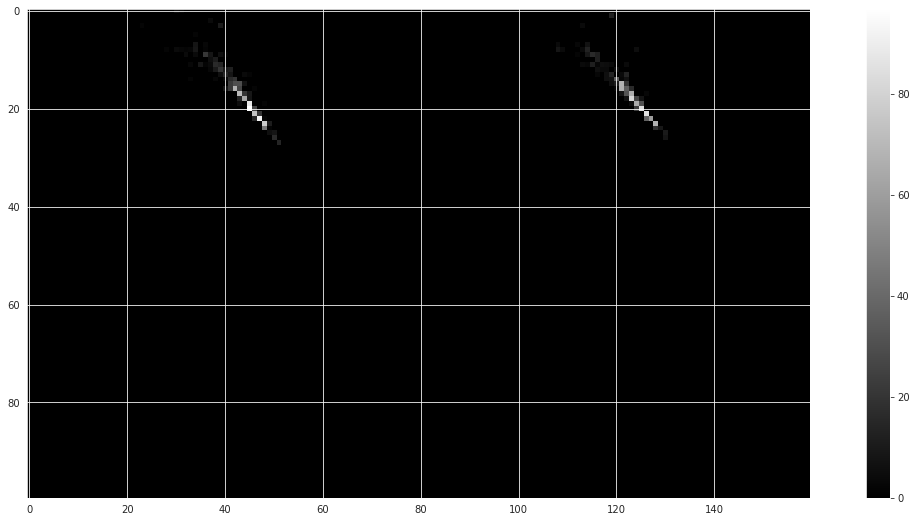

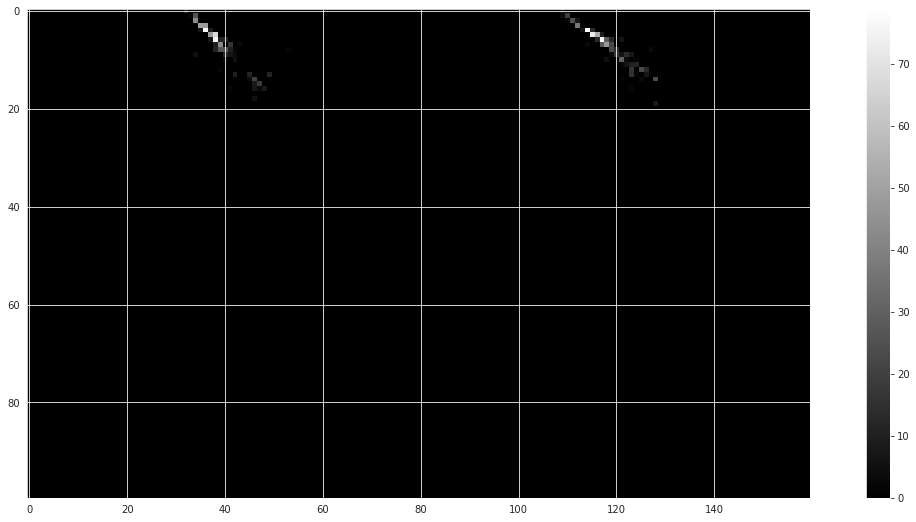

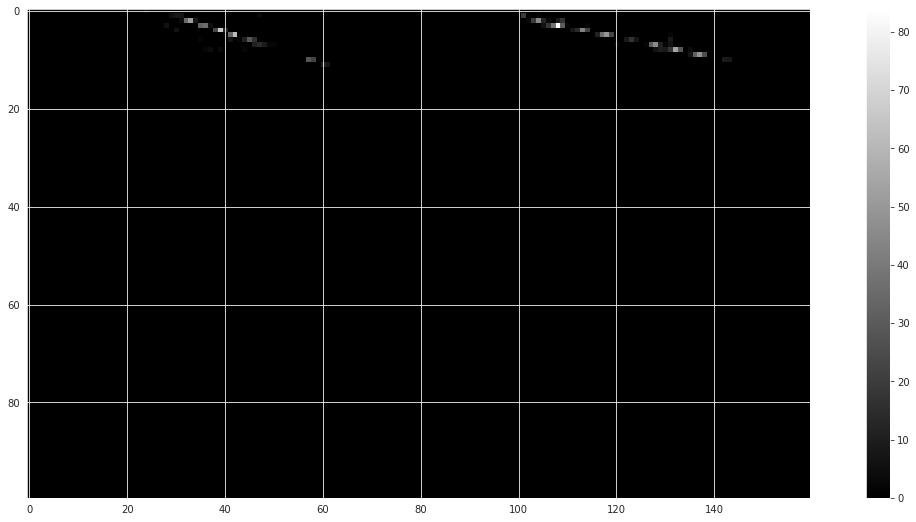

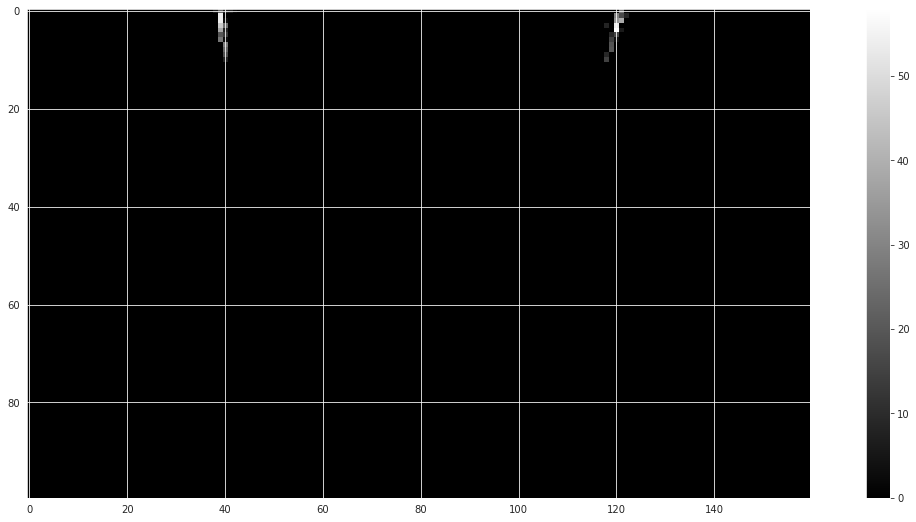

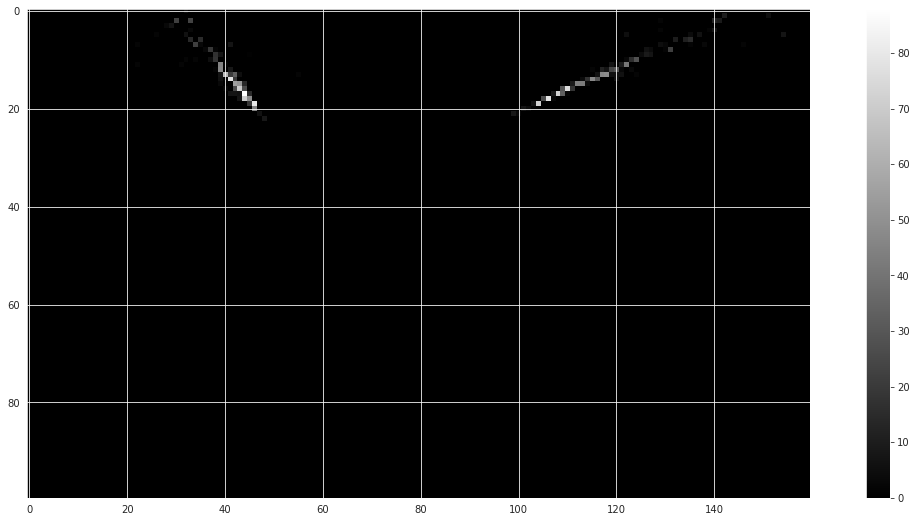

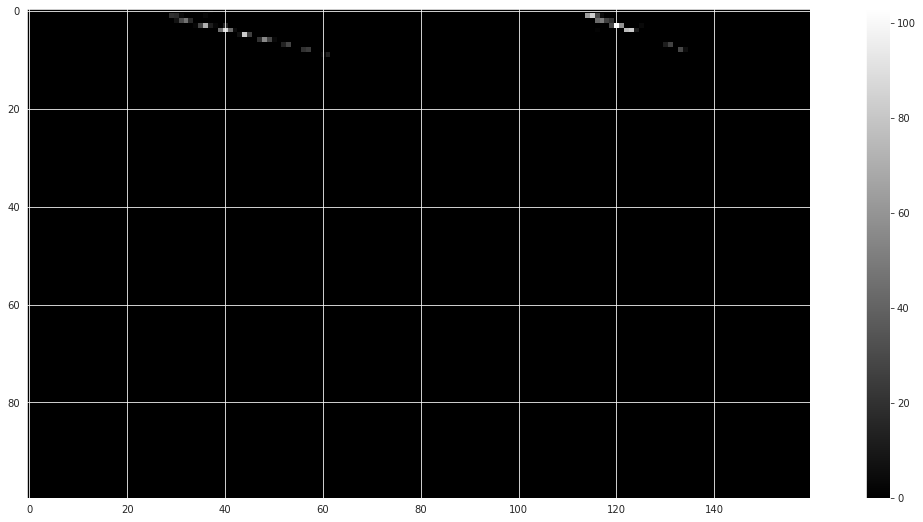

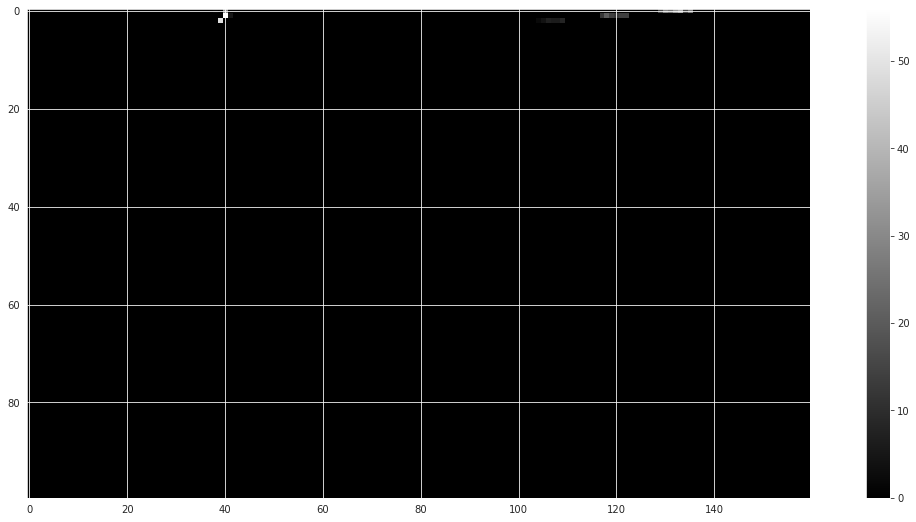

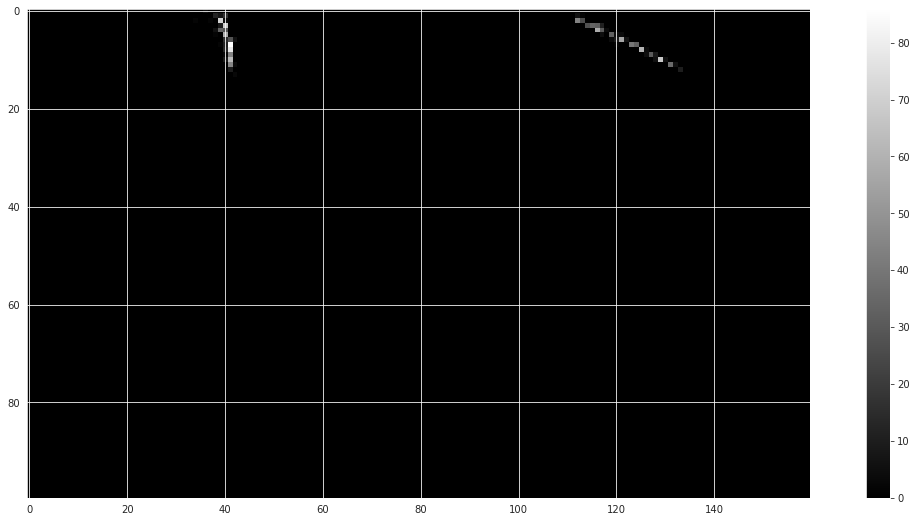

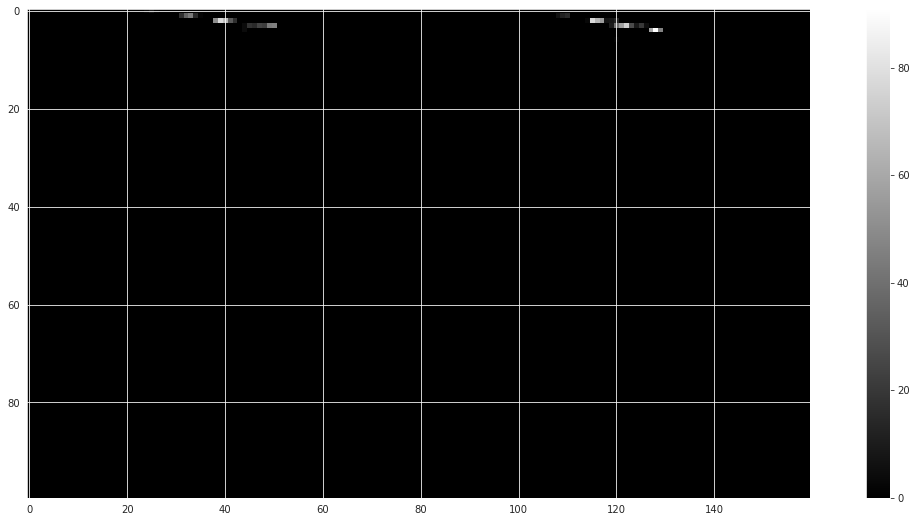

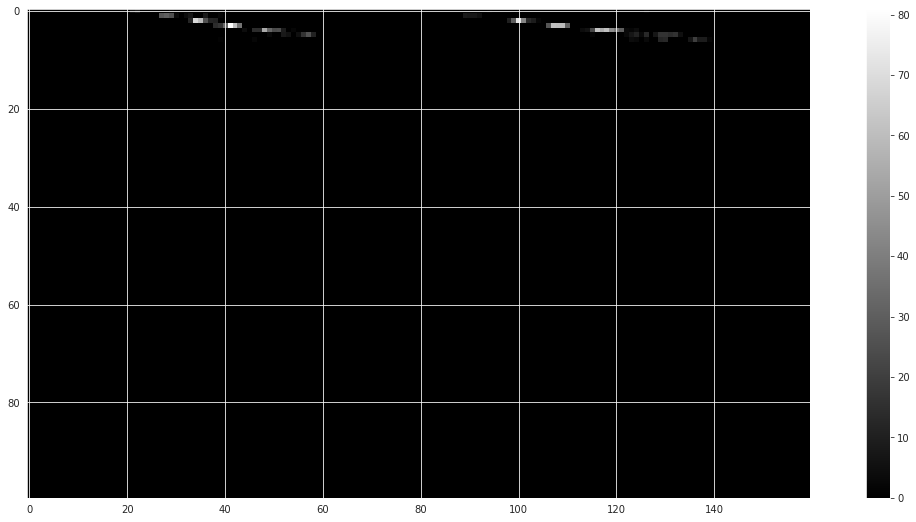

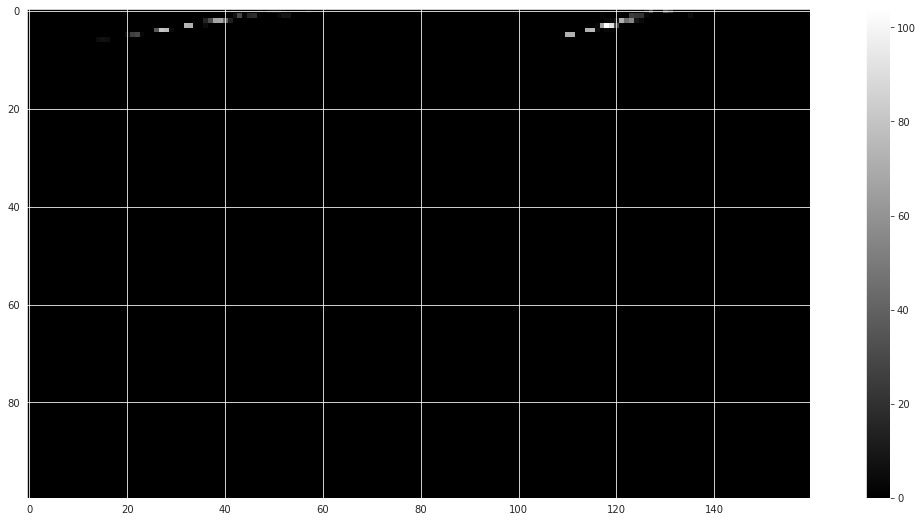

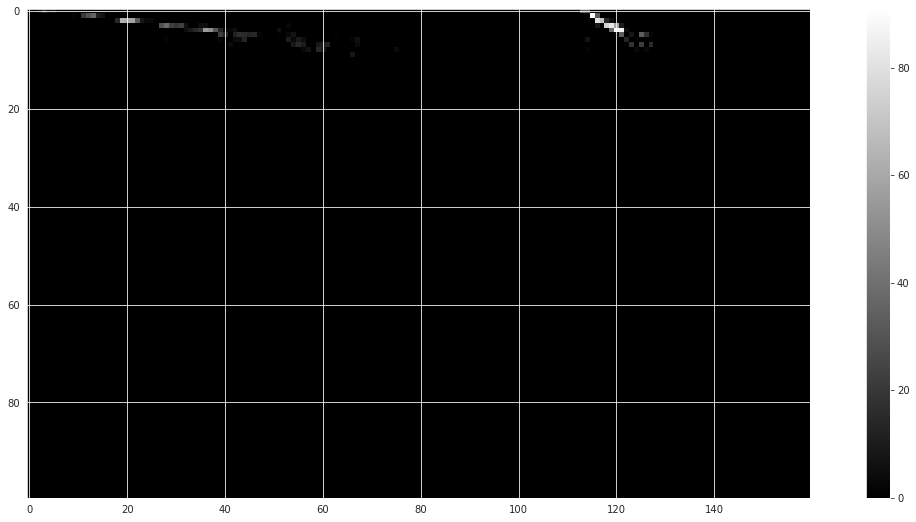

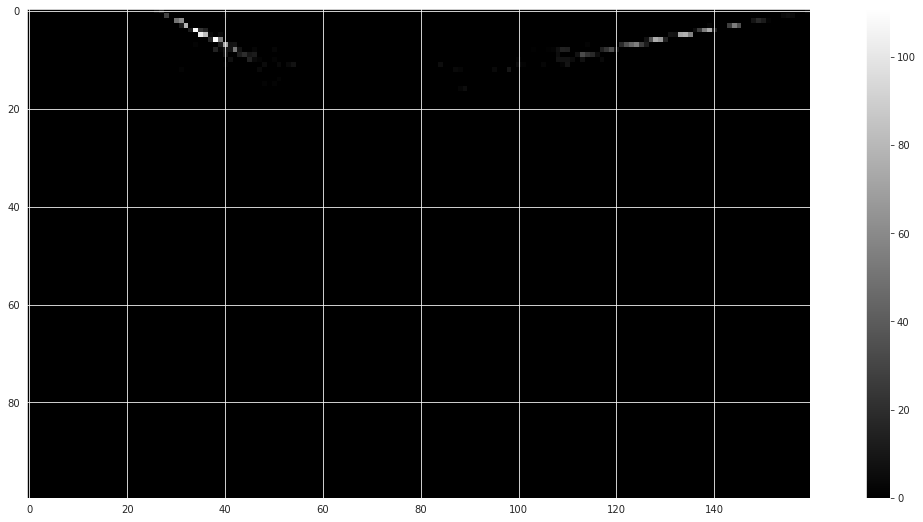

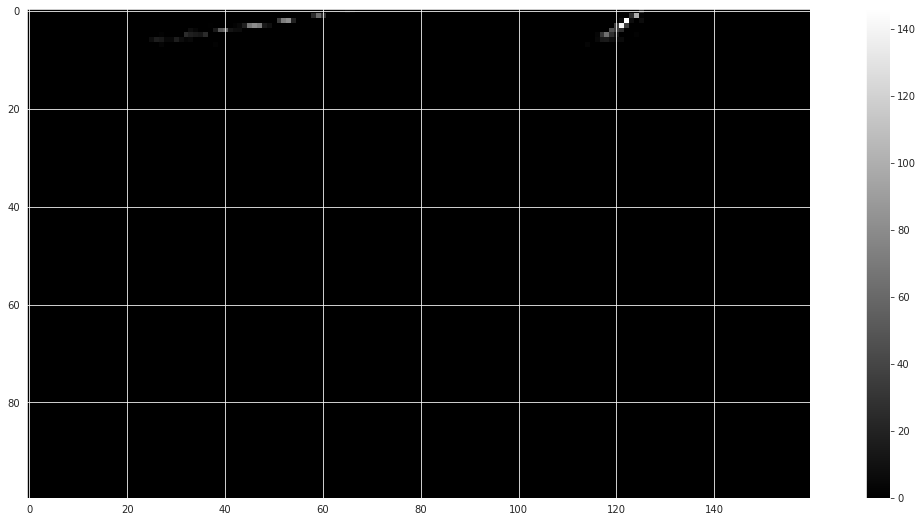

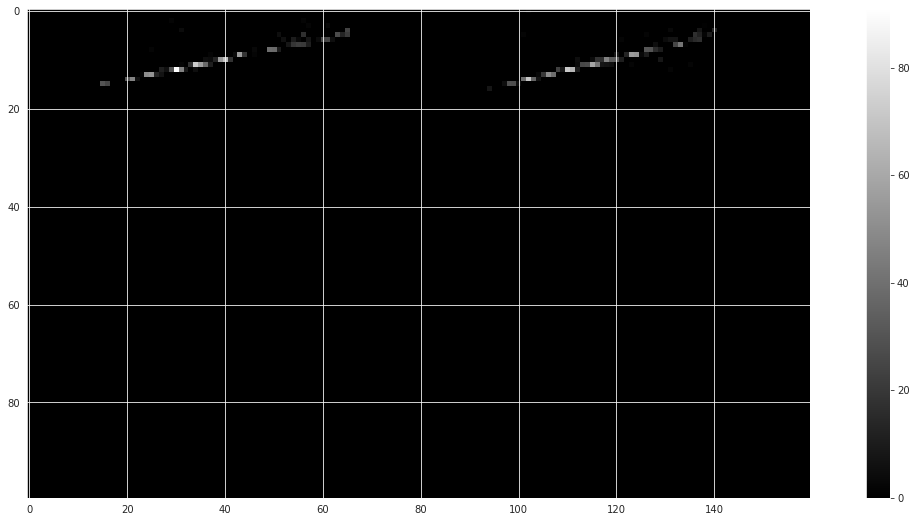

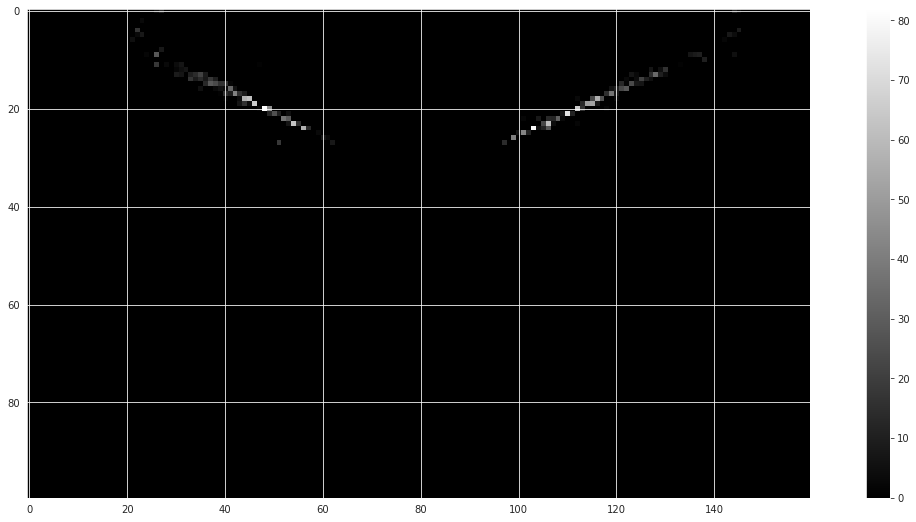

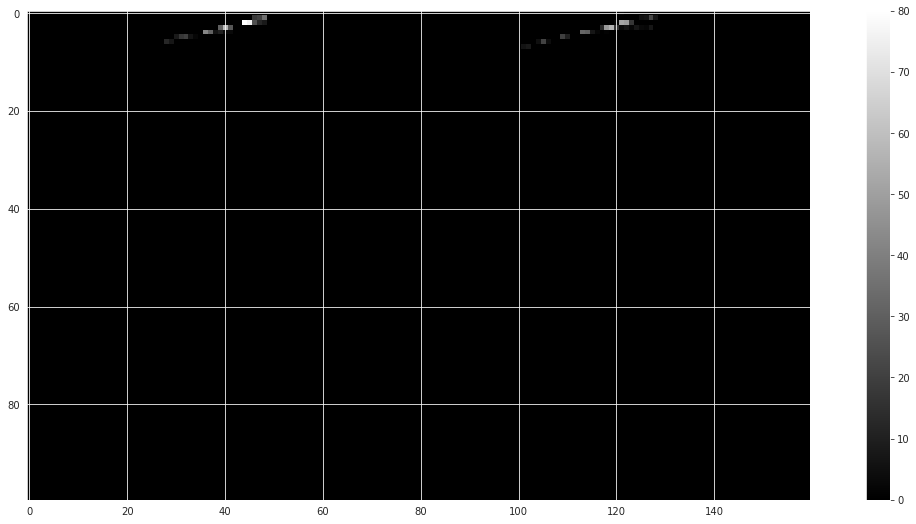

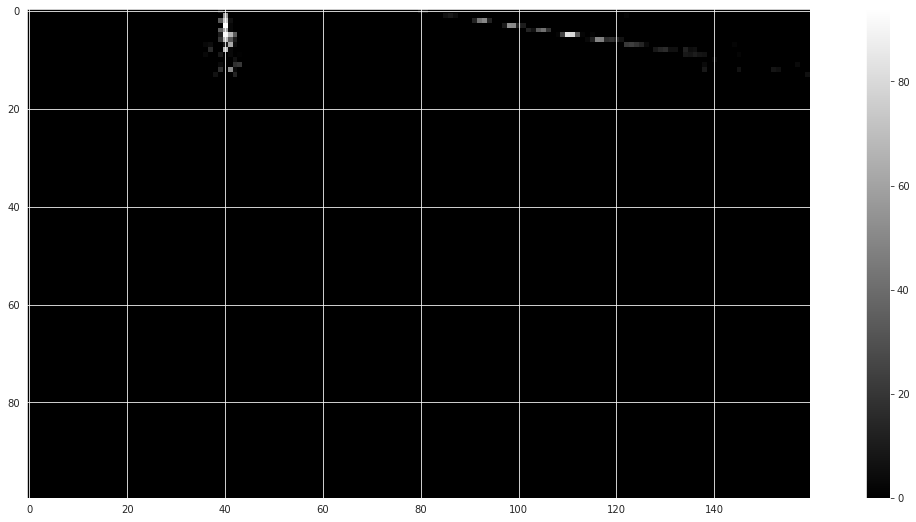

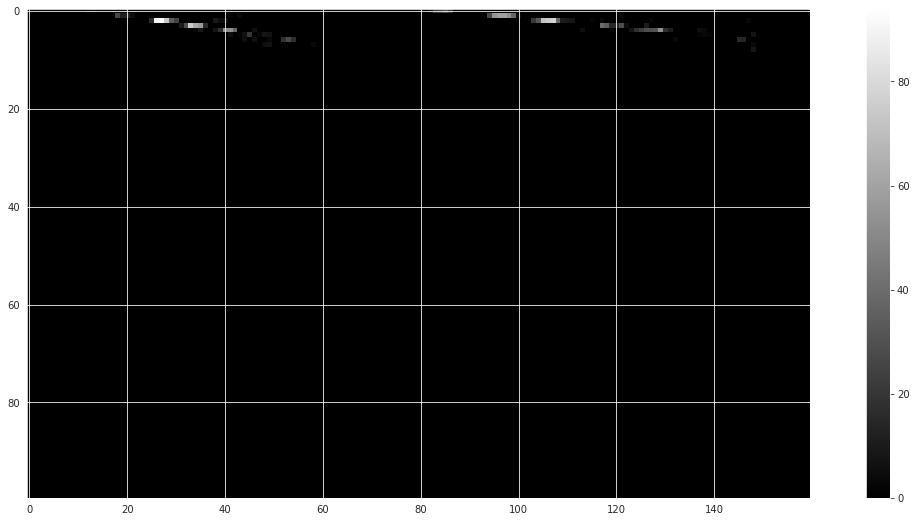

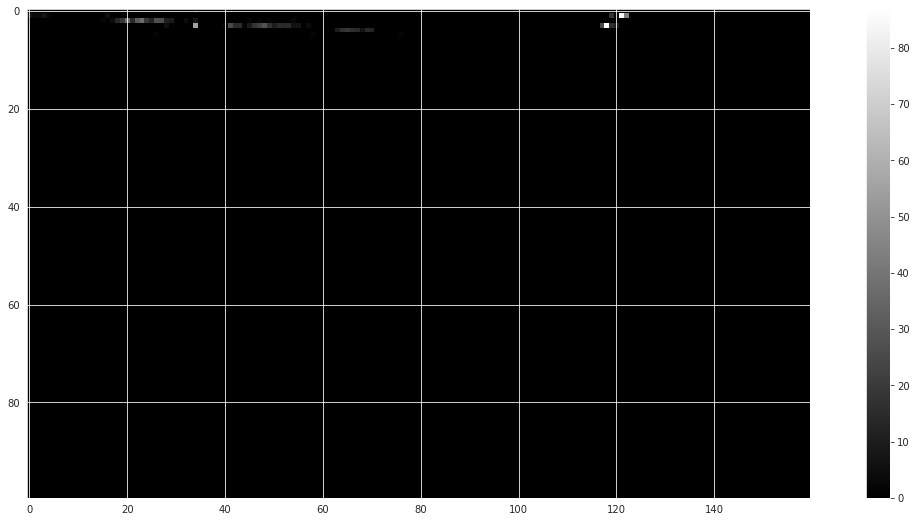

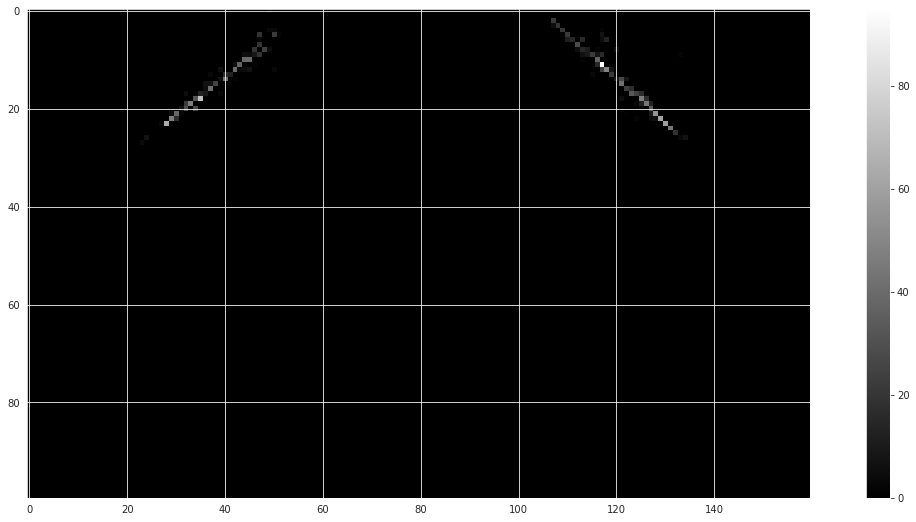

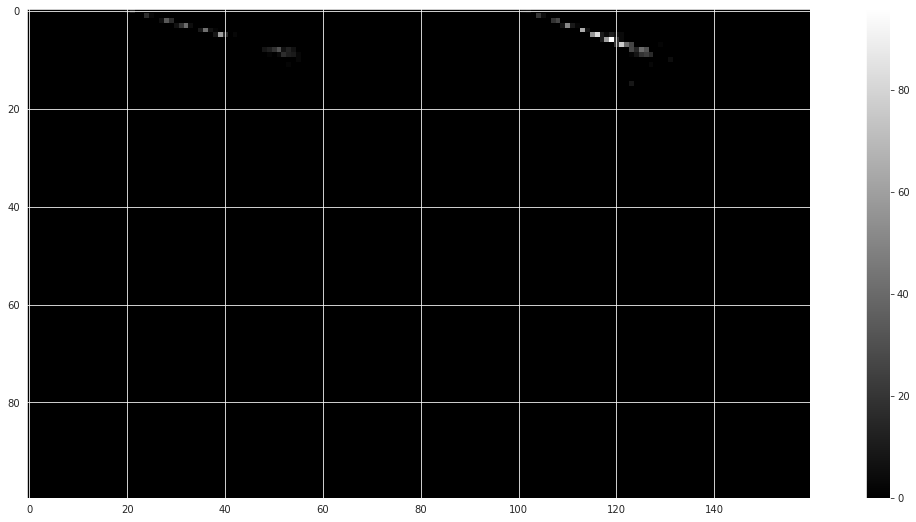

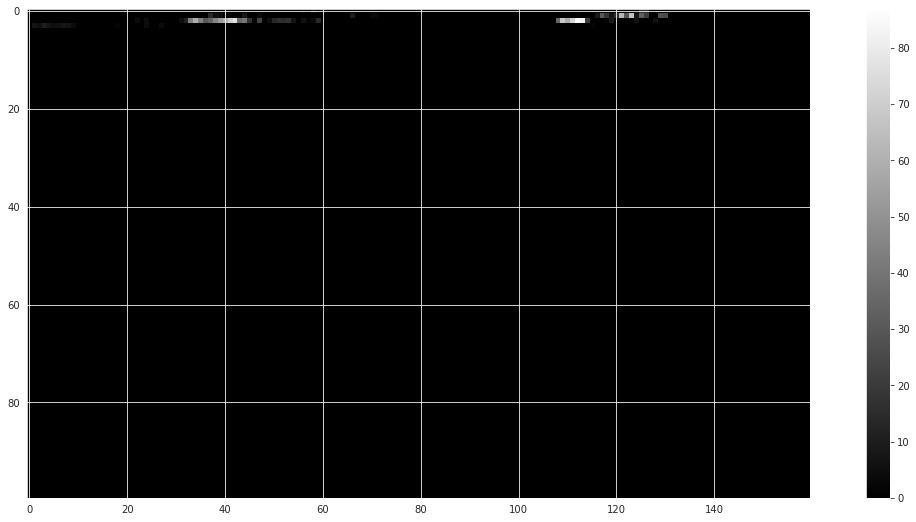

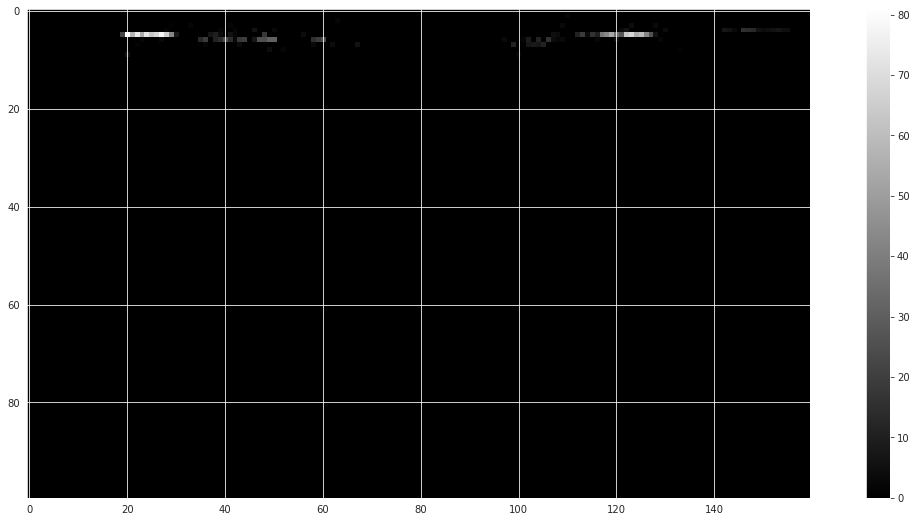

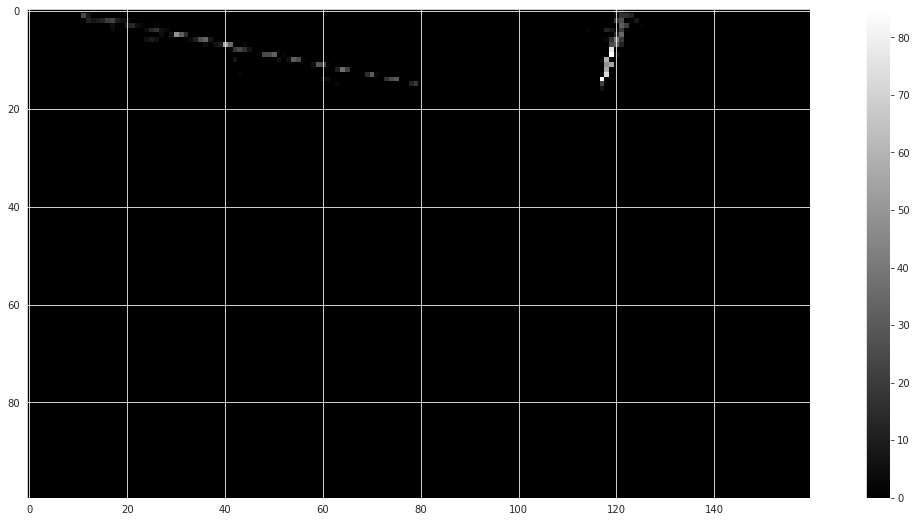

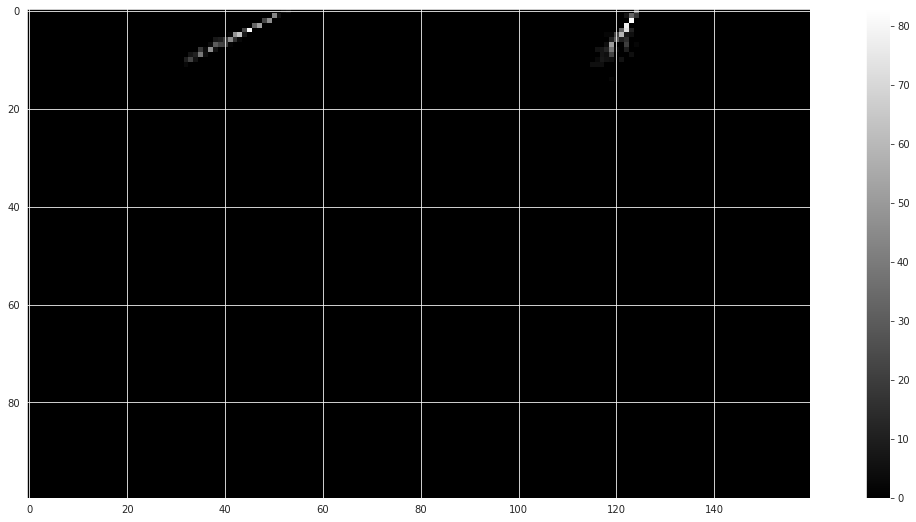

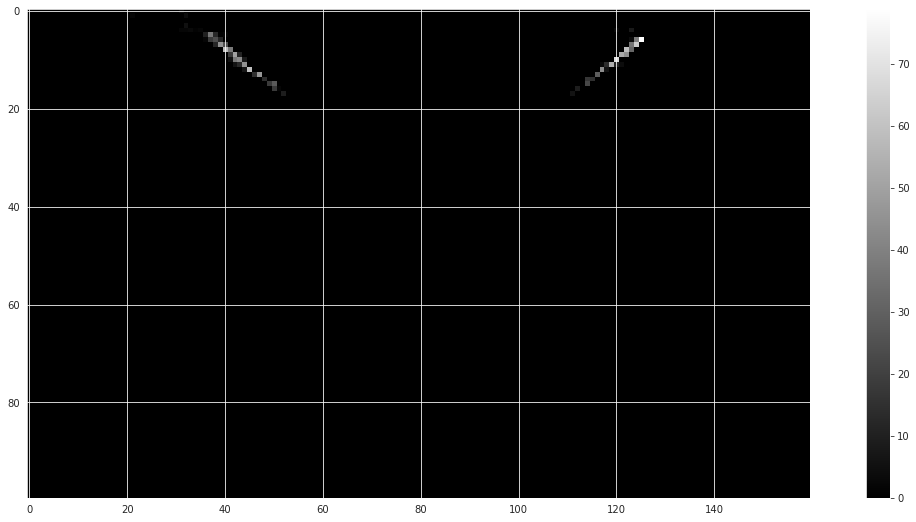

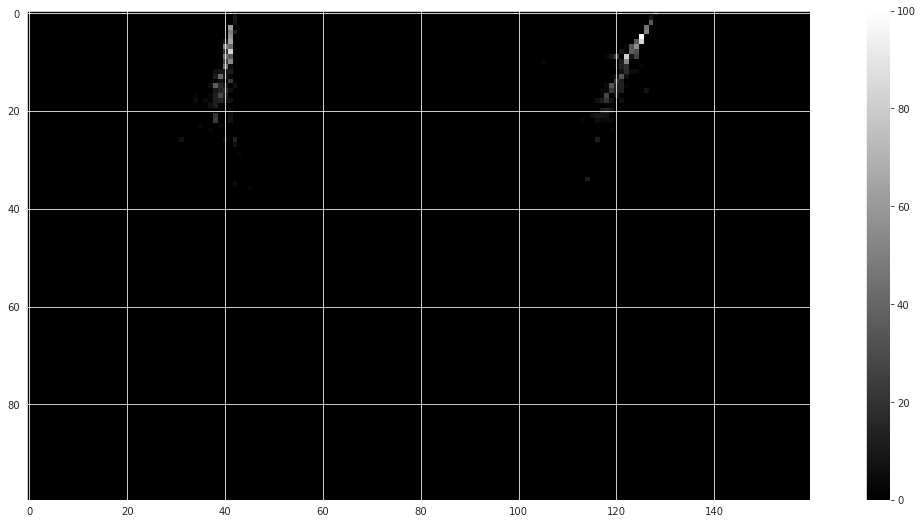

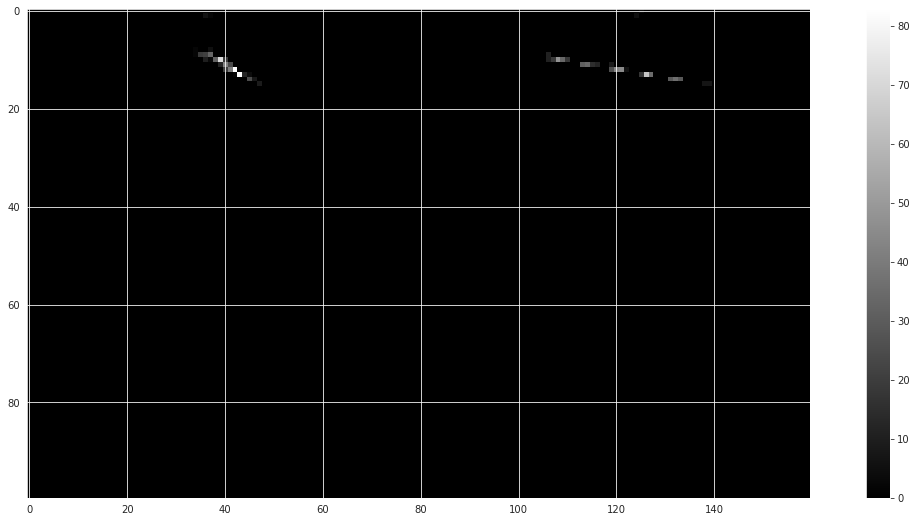

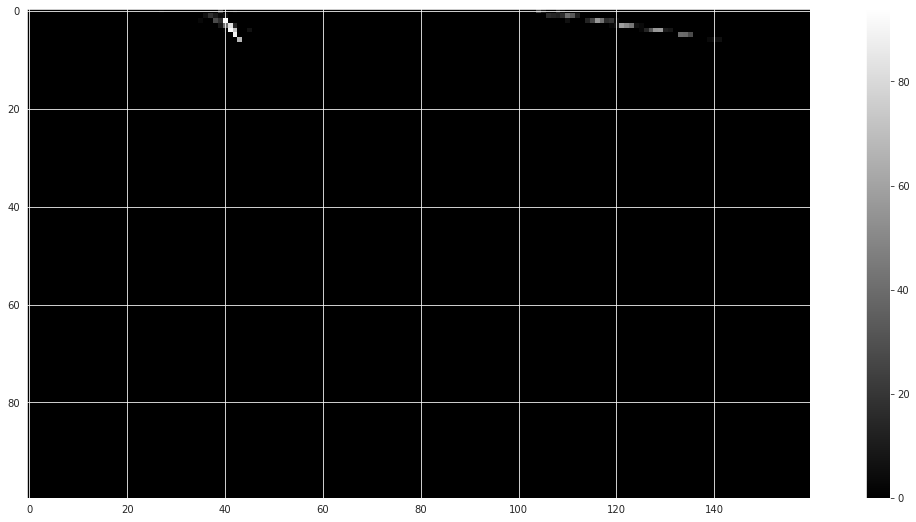

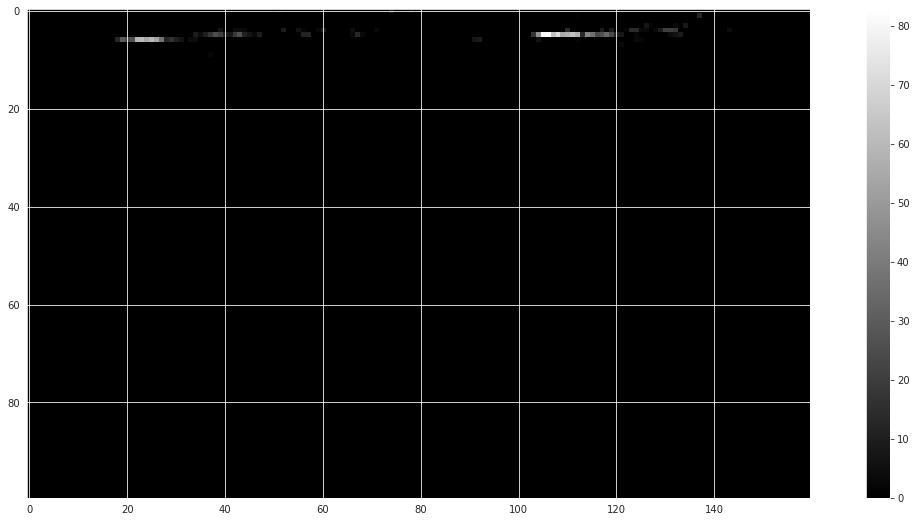

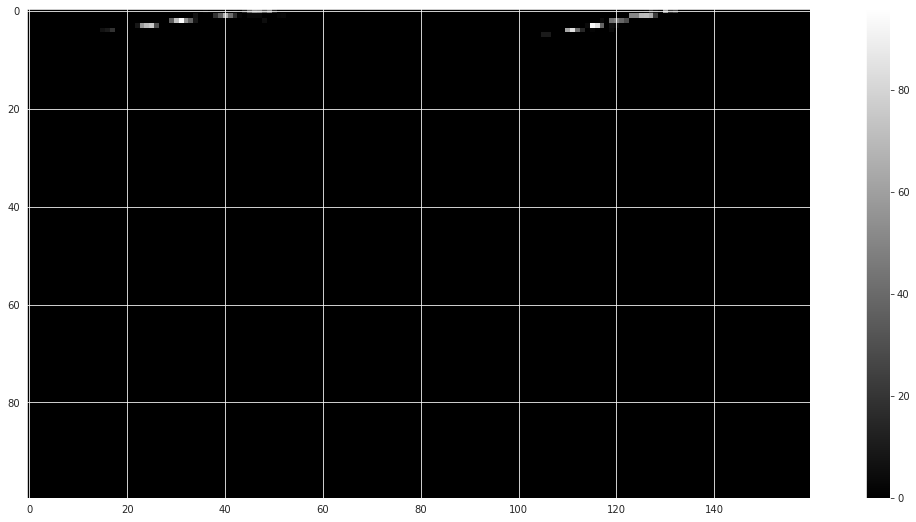

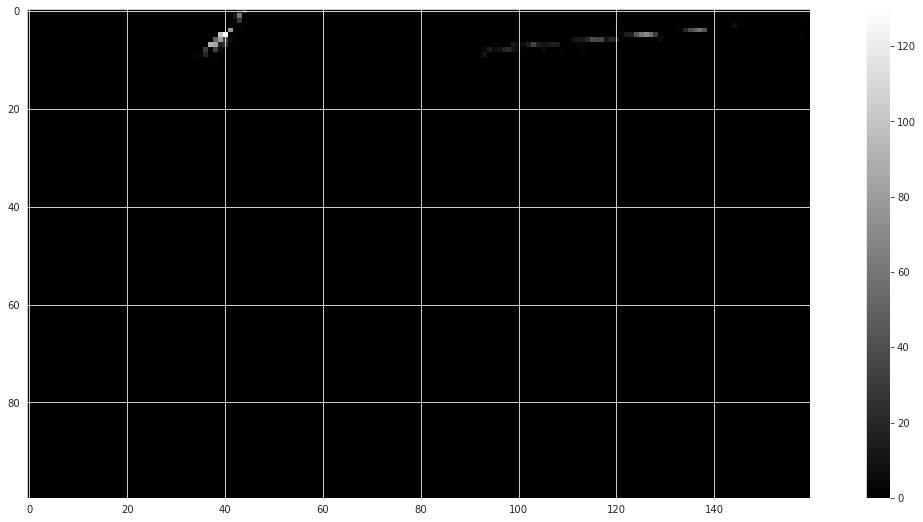

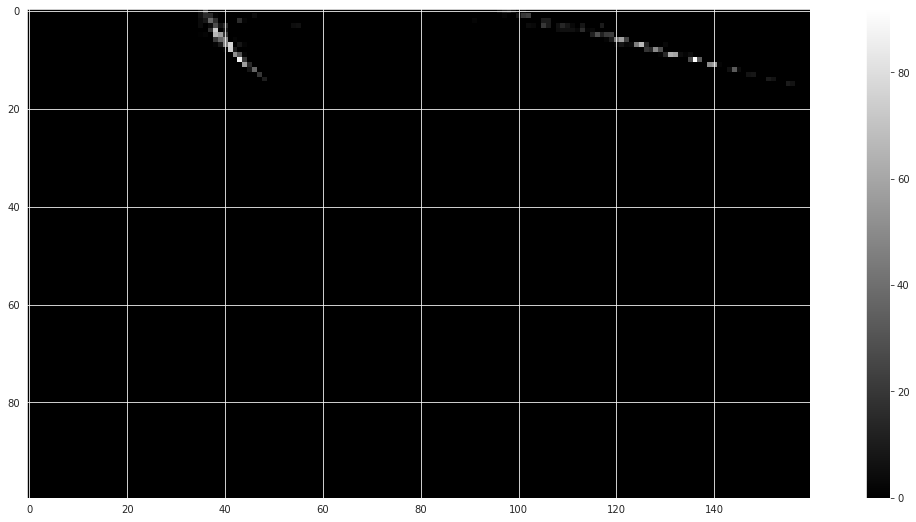

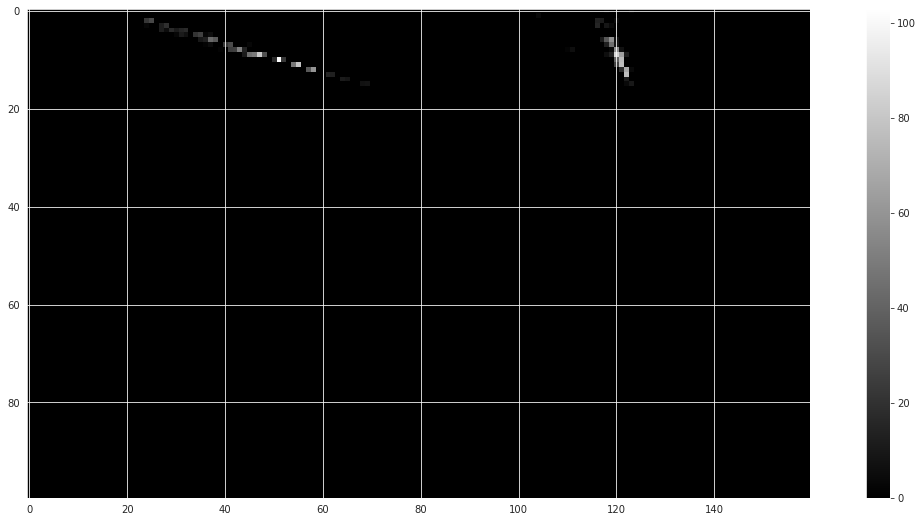

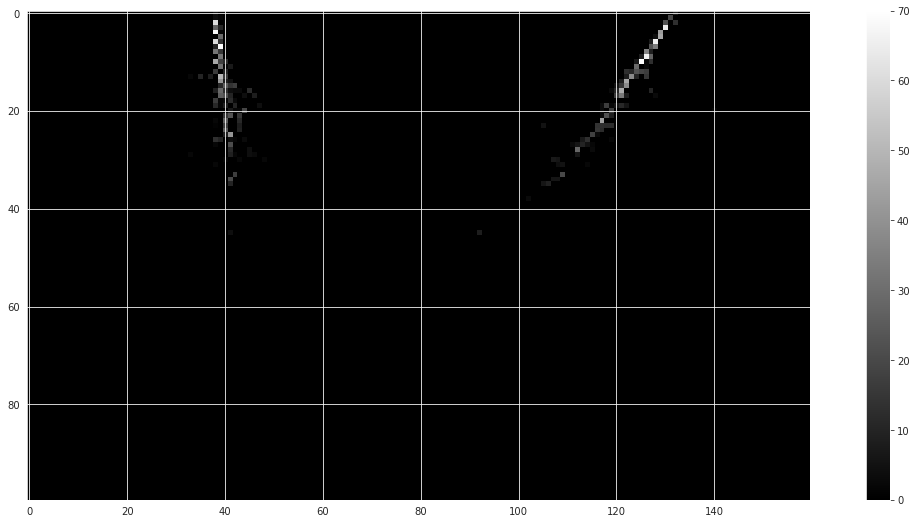

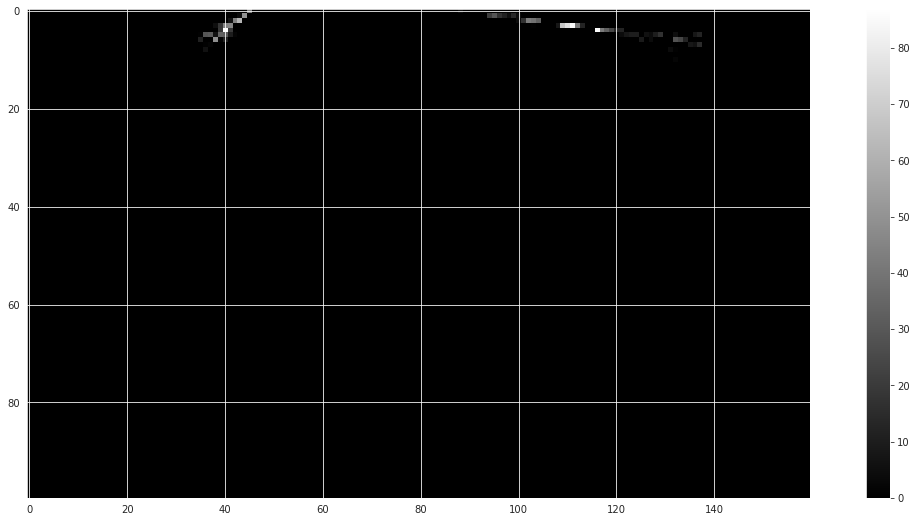

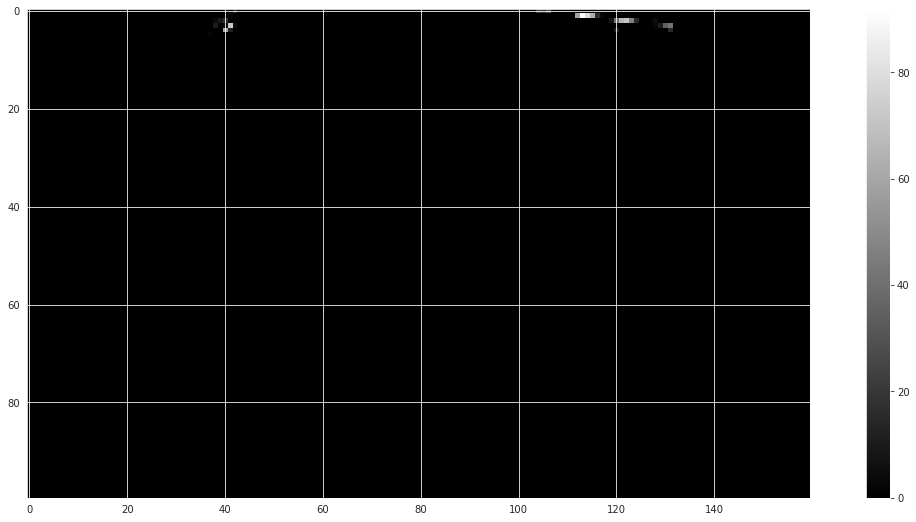

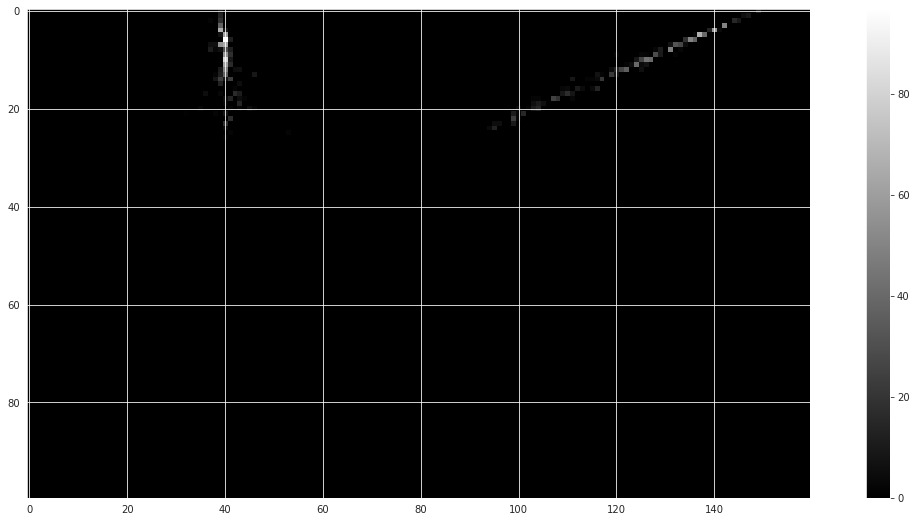

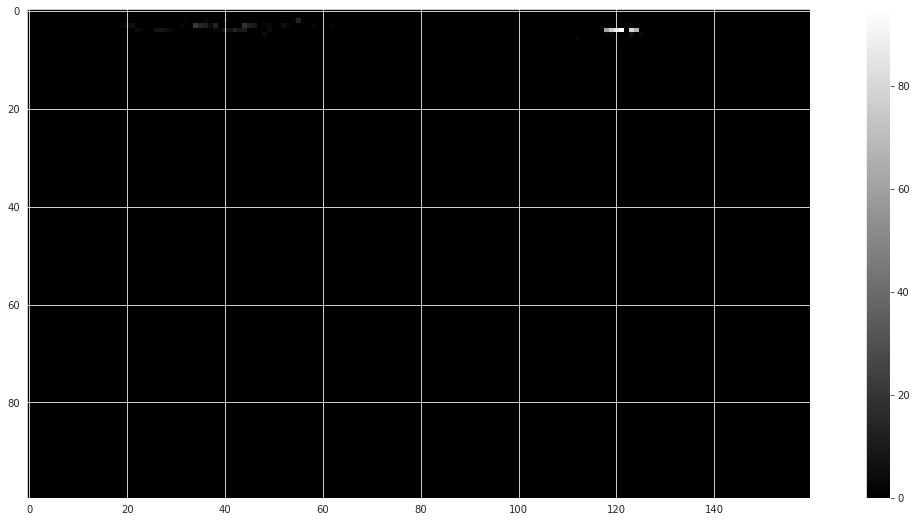

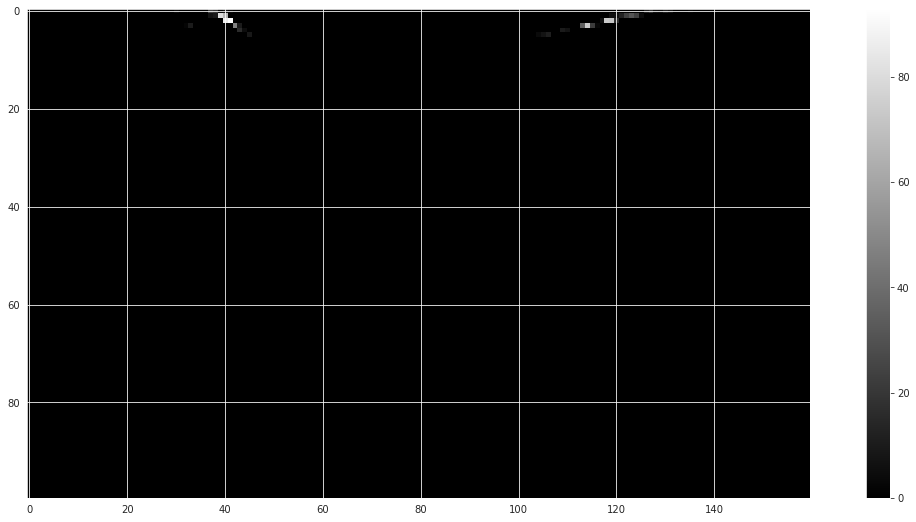

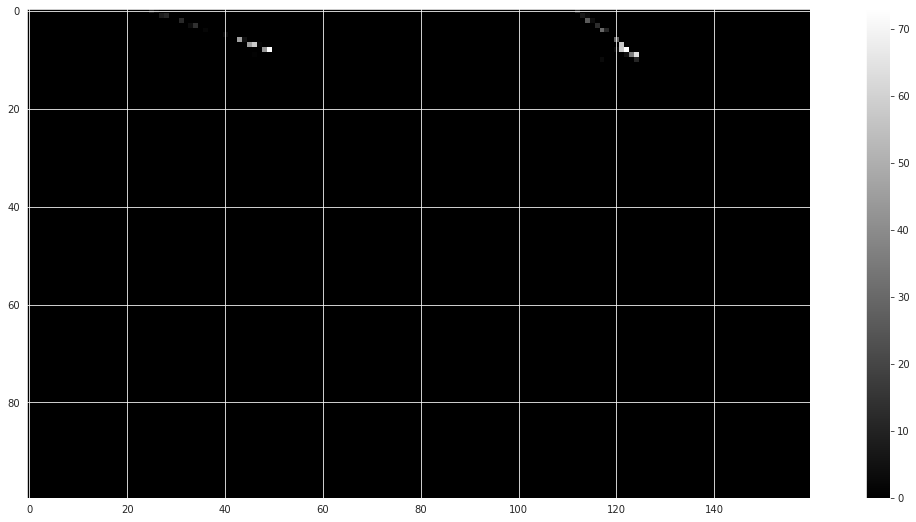

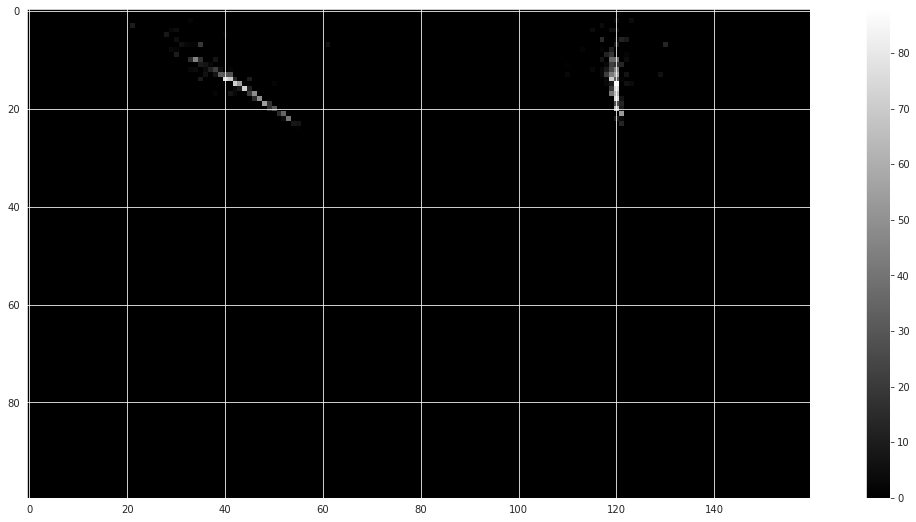

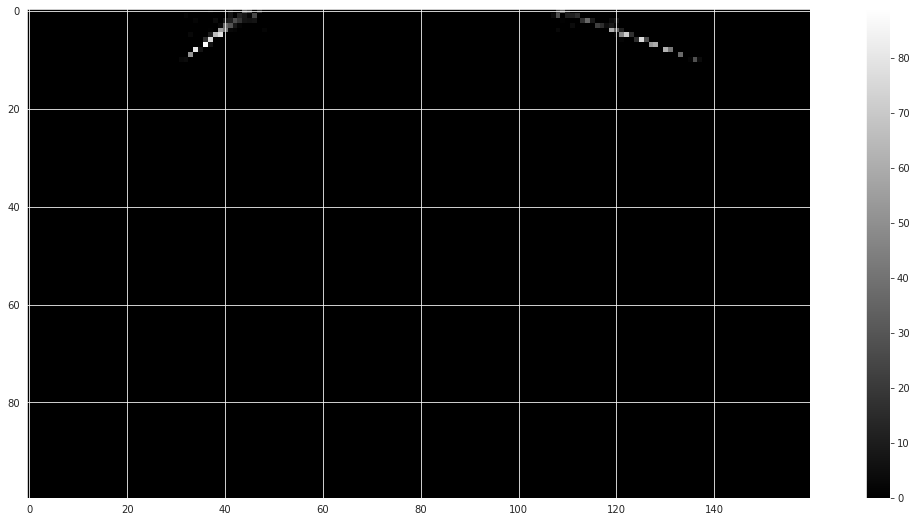

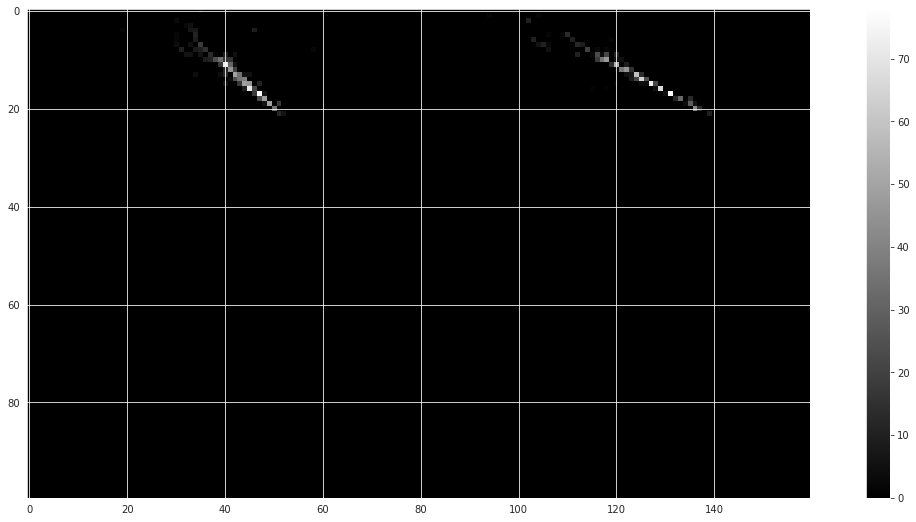

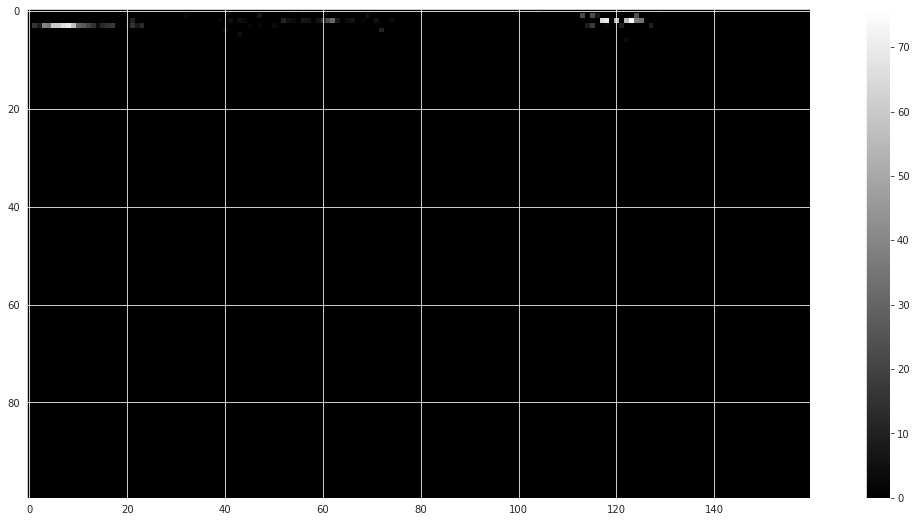

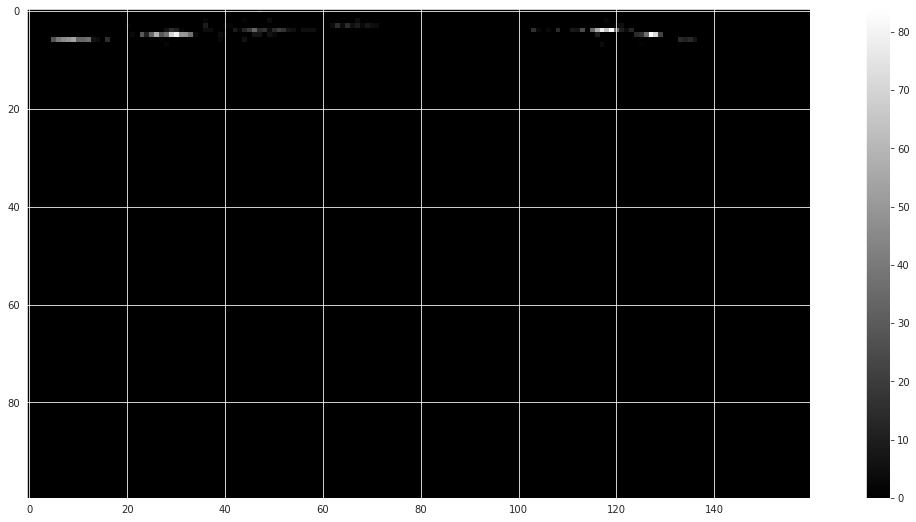

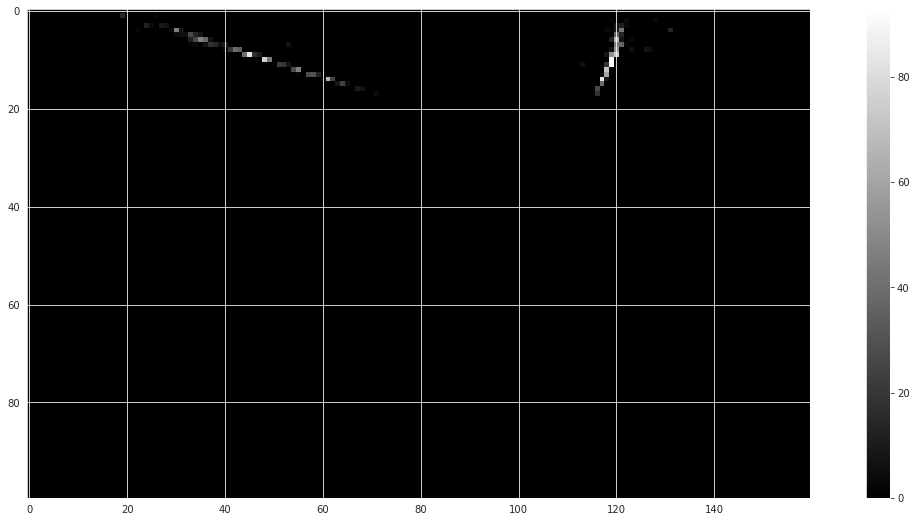

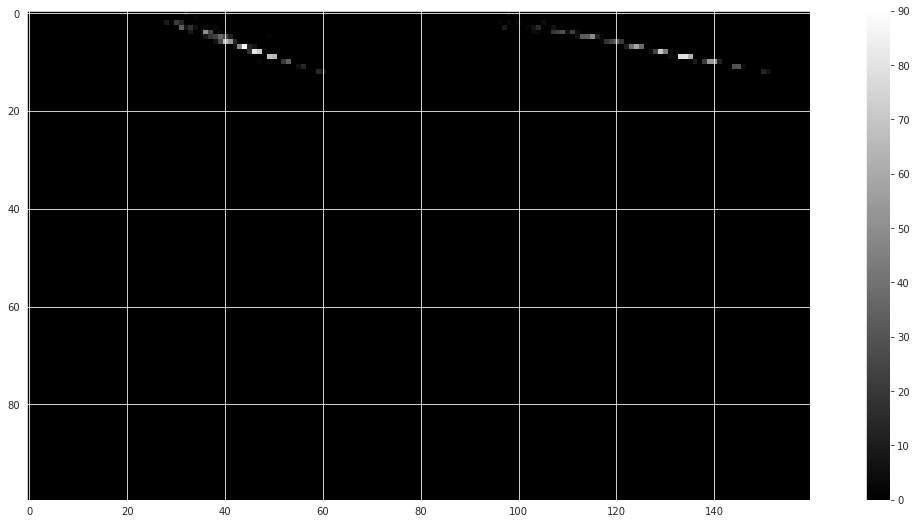

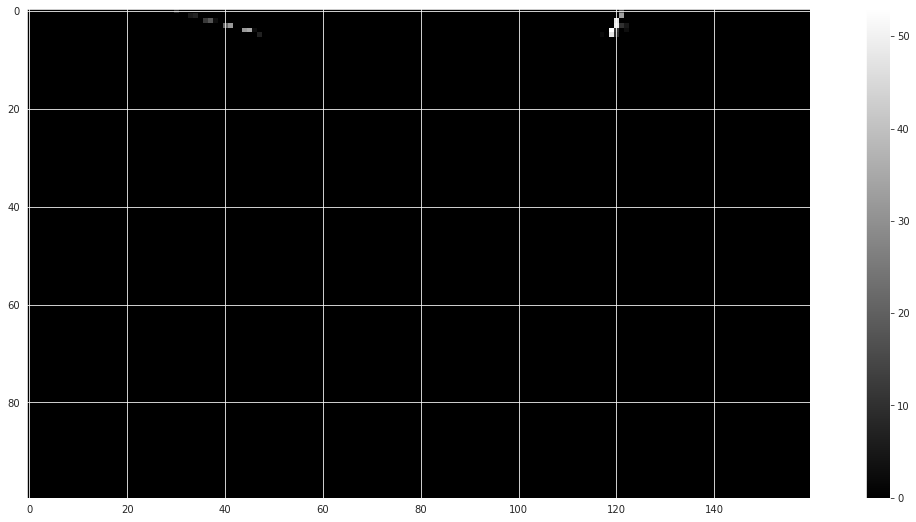

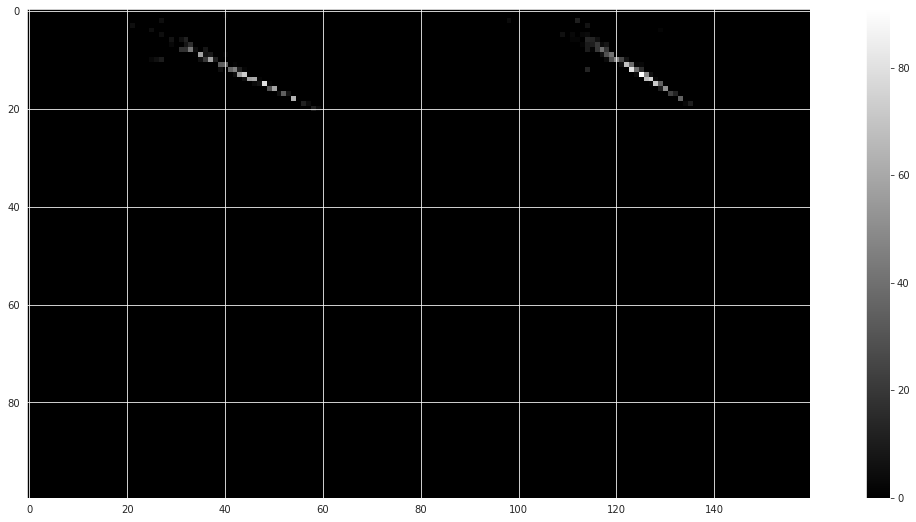

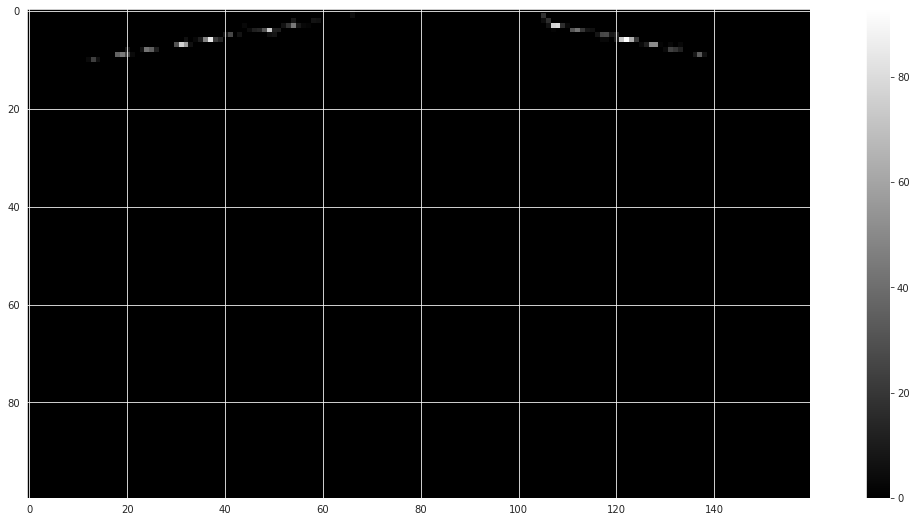

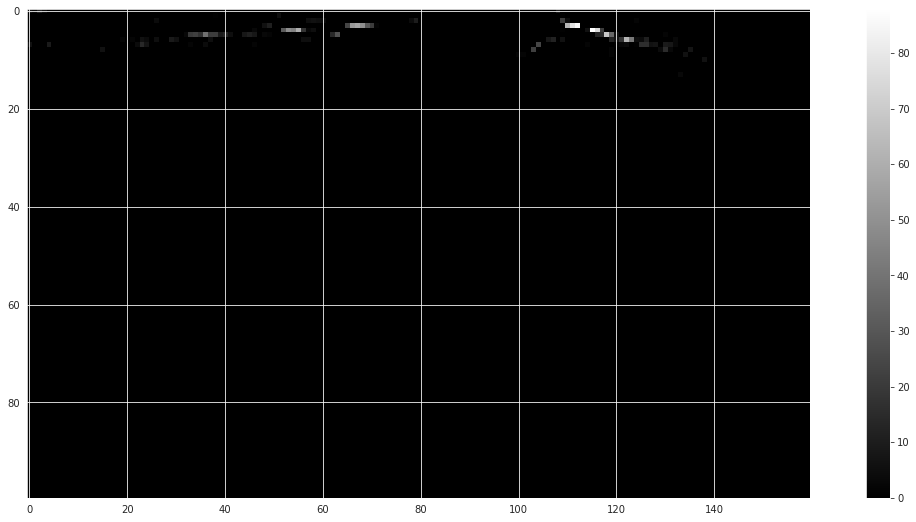

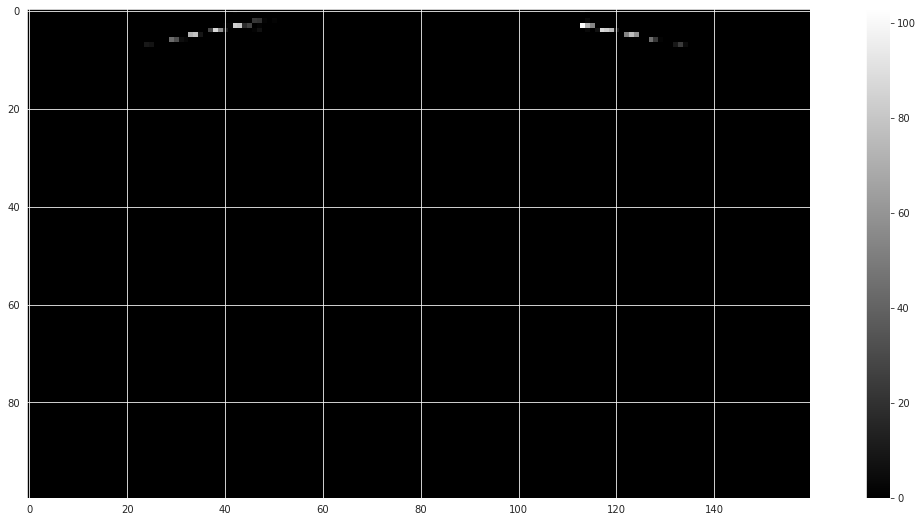

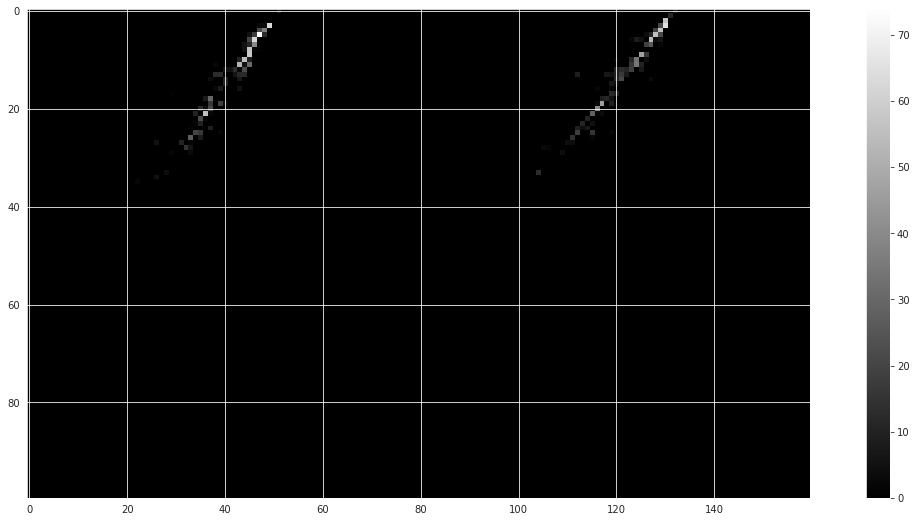

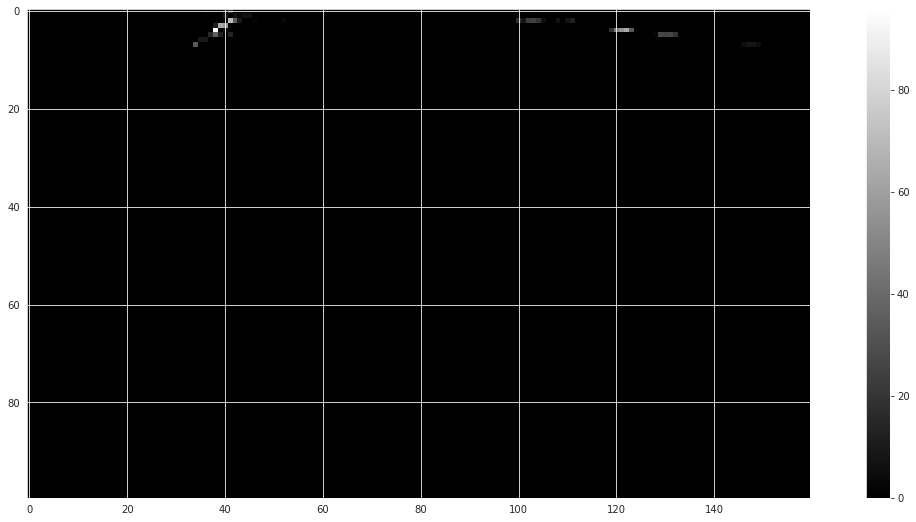

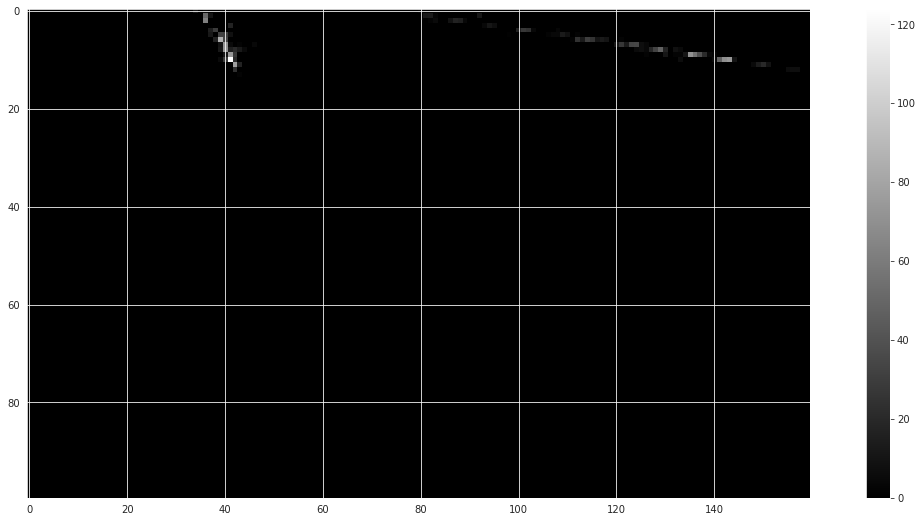

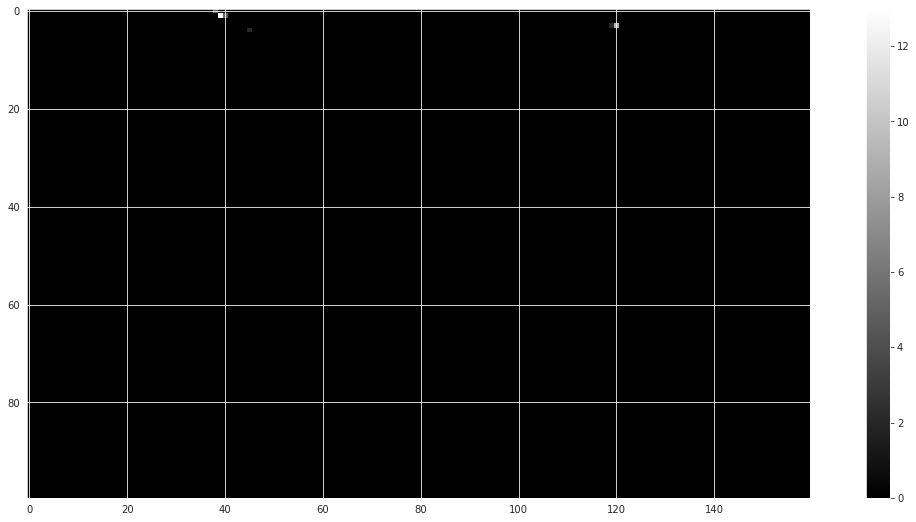

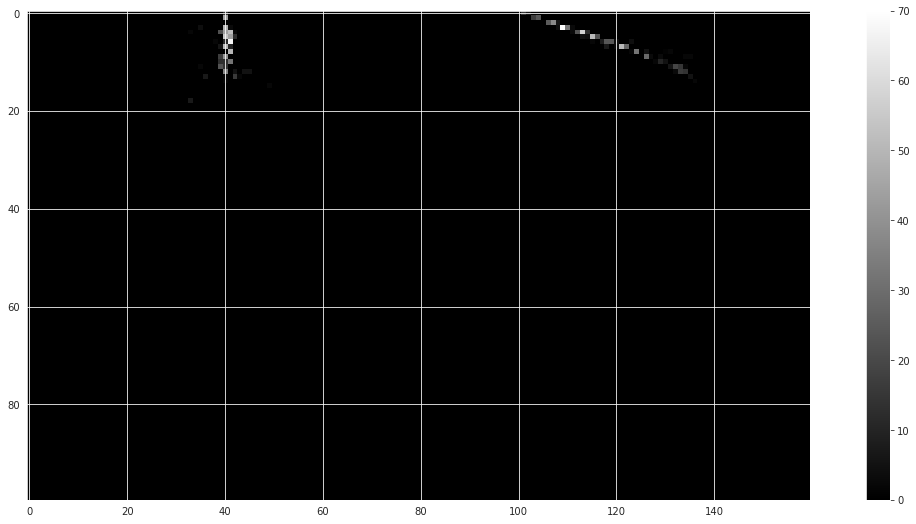

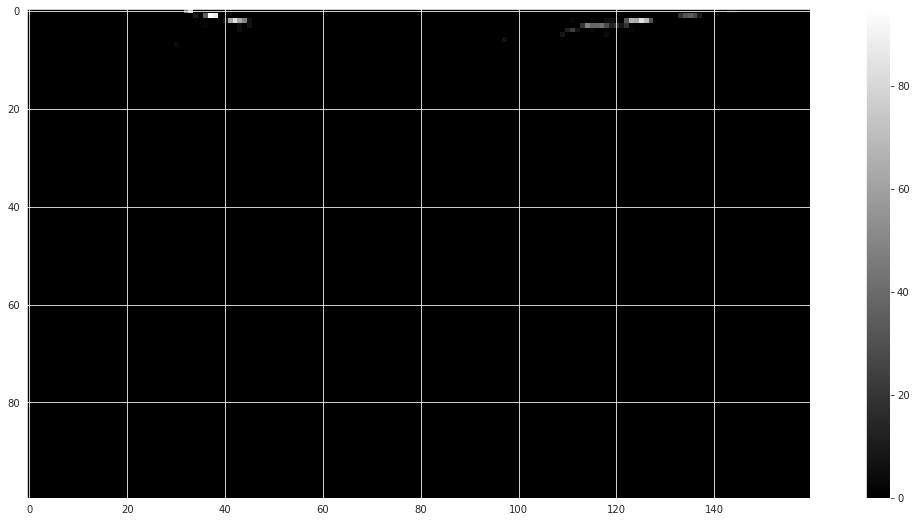

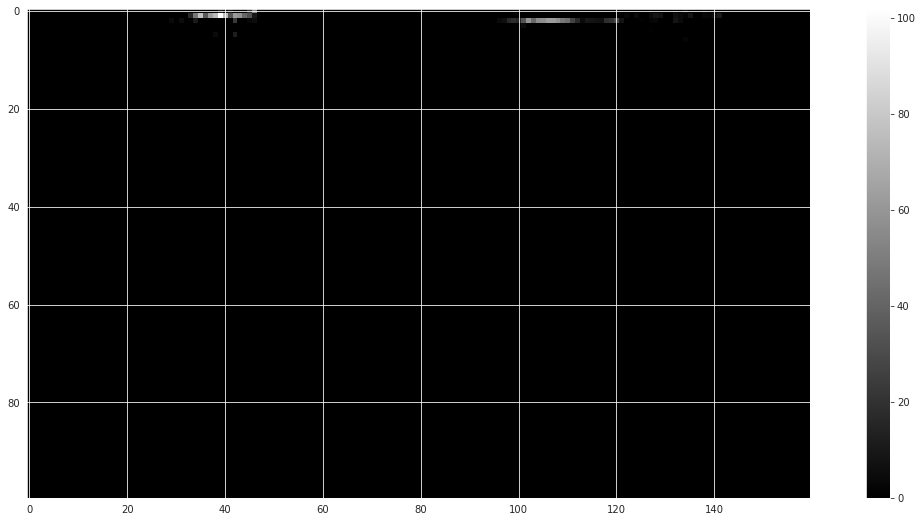

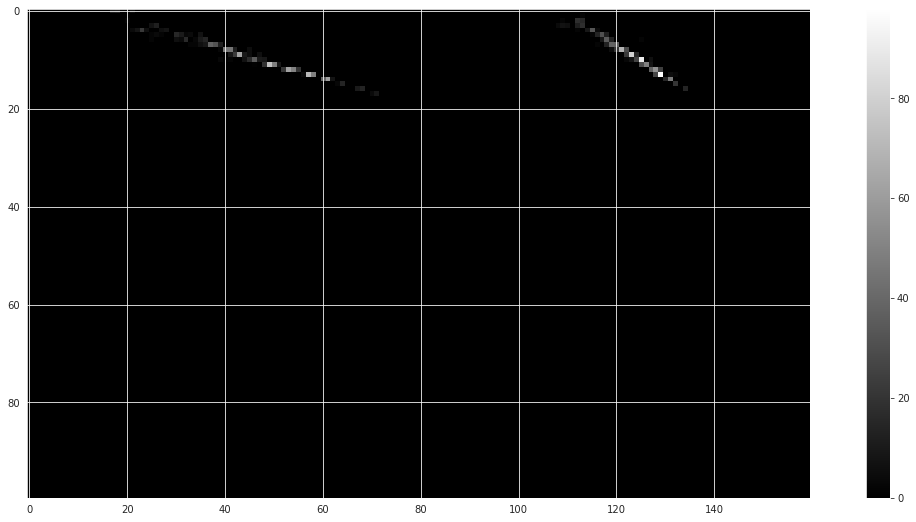

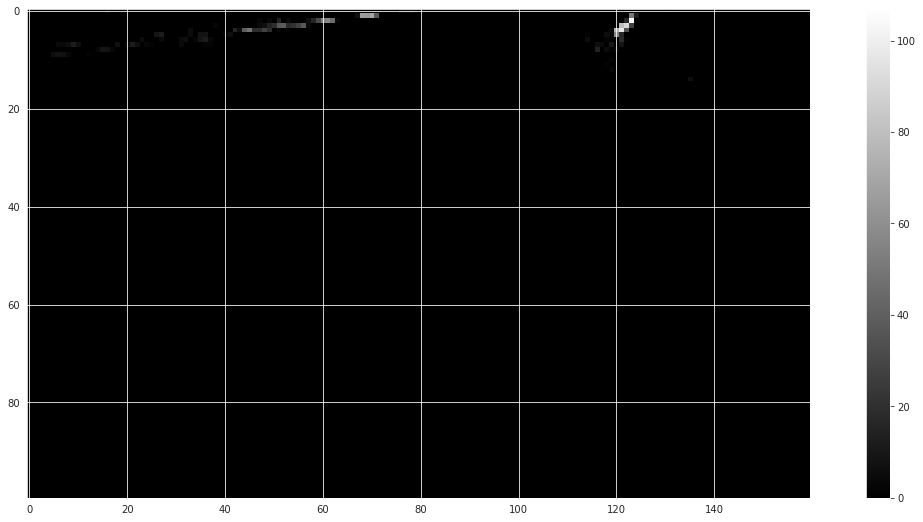

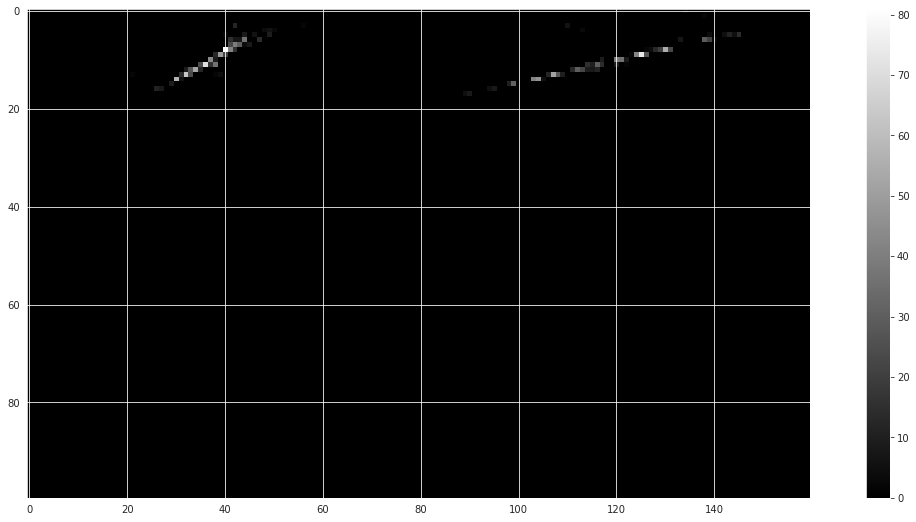

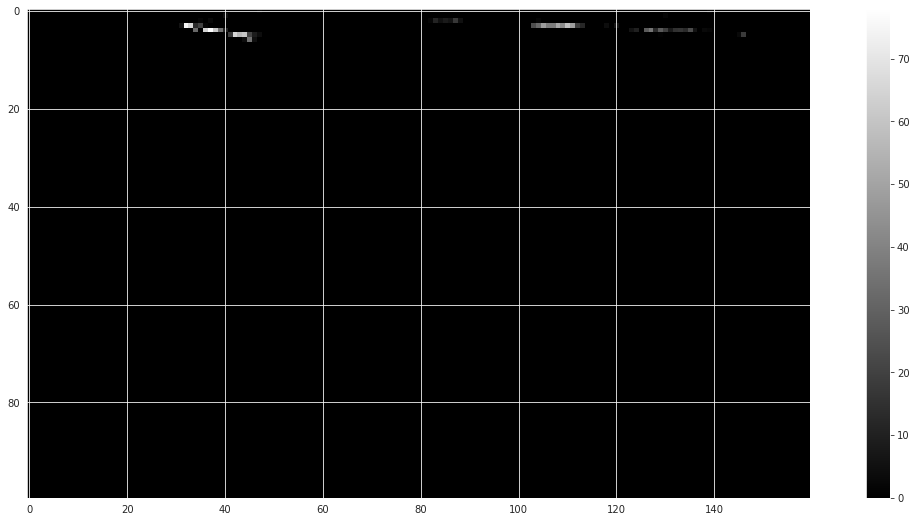

In [9]:
for i in range(len(df)):
    pm=df.iloc[i,44:16044].values
    pm=pm.reshape((2,100,80))
    pm=np.concatenate((pm[0].reshape((100,80)),pm[1].reshape((100,80))),axis = 1)
    pm = np.stack((pm,)*3, axis=-1)
    max=np.max(pm)
    pm= pm /max
    plt.imshow(pm.astype(float),cmap='gray',vmin=0, vmax=max)
    plt.colorbar()
    plt.show()
    img = im.fromarray((pm * 255).astype(np.uint8))

    img.save('./plots/electrones p.E> 2/'
             +str(df.iloc[i]['nhitslc'])+'-'
             +str(df.iloc[i]['p.E'])+'-'
             +str(df.iloc[i]['euclidean'])+'.jpg')


